# 06_1_TEST_LibraryCharacterisation

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/06_1_TEST_LibraryCharacterisation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 


In [73]:
# handy line of code if we want to 
pd.set_option('display.max_rows', 50)

In [74]:
%%capture
!pip install xlrd
!pip install --upgrade xlrd
!pip install ConStrain

In [75]:
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


# 1. DATA wrangling

In this section the objective is to: 
    
    1. Import data from LC-MS analysis
    2. Merge that data with information on the plate setup and enzyme homologs (i.e. what each well has produced)
    3. Import sequencing data - filter it
    4. Genotype the different wells with which promoters was used
    5. Merge all the data so we end up with the following for each well analysed: 
        - Normalized production of strictosidine
        - Homolog combination 
        - Promoter combination 

With this information we can go to the next step which is the ML step. 

## 1.1 Merge Plate design yp49-52 metadata into single csv file


In [83]:
# importing xls file
xls = pd.ExcelFile('../data/raw/023_LC-MS/excel_files/plateDesign_yp48-51_MIA-HA-1-17_21-100.xls')

# reading the different sheets
df1 = pd.read_excel(xls, 'MIA-HA-1-17_yp48')  # plate 48
df1["plate"] = 'yp48' 

df2 = pd.read_excel(xls, 'MIA-HA-51-80_yp49') # plate 49
df2["plate"] = 'yp49' 

df3 = pd.read_excel(xls, 'MIA-HA-21-50_yp50') # plate 50
df3["plate"] = 'yp50' 

df4 = pd.read_excel(xls, 'MIA-HA-81-100_yp51')# plate 51
df4["plate"] = 'yp51' 

df5 = pd.read_excel(xls, 'yp52-HA-71-72')     # plate 52 has a few replicates that failed first time they were injected into the 
df5["plate"] = 'yp52' 


In [84]:
results_merged = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

In [85]:
results_merged

,position,Sample name,Cellular Compartment,Medium,Sample Type,Temperature (C),Timepoint (h),Cultivation Container ID/Position,Operator Name,Replicate #,Strain,genotype,plate,Cellular compartment
0,A01,NaN,NaN,YPD,Blank,30.0,144.0,NaN,Soeren Petersen,NaN,NaN,NaN,yp48,NaN
1,A02,NaN,NaN,YPD,Blank,30.0,144.0,NaN,Soeren Petersen,NaN,NaN,NaN,yp48,NaN
2,A03,NaN,NaN,YPD,Blank,30.0,144.0,NaN,Soeren Petersen,NaN,NaN,NaN,yp48,NaN
3,A04,NaN,NaN,YPD,Blank,30.0,144.0,NaN,Soeren Petersen,NaN,NaN,NaN,yp48,NaN
4,A05,NaN,NaN,YPD,Blank,30.0,144.0,NaN,Soeren Petersen,NaN,NaN,NaN,yp48,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,H08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp52,NaN
572,H09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp52,NaN
573,H10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp52,NaN
574,H11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp52,NaN


In [86]:
results_merged.to_csv('ConStrain_on_google_colab/Data/processed/023_LC-MS/yp48-52_meta_analytics1.csv', header = True, index = False)

In [87]:
# read into a dataframe
PlateDesign = pd.read_csv('ConStrain_on_google_colab/Data/processed/023_LC-MS/yp48-52_meta_analytics1.csv') 

In [88]:
# we take the columns that we are interested in
PlateDesign= PlateDesign[['plate','position','Strain', 'Replicate #', 'genotype', 'Medium']]
# rename them
PlateDesign.columns = ['plate', 'well', 'strain','col_no', 'genotype', 'medium']
PlateDesign

,plate,well,strain,col_no,genotype,medium
0,yp48,A01,NaN,NaN,NaN,YPD
1,yp48,A02,NaN,NaN,NaN,YPD
2,yp48,A03,NaN,NaN,NaN,YPD
3,yp48,A04,NaN,NaN,NaN,YPD
4,yp48,A05,NaN,NaN,NaN,YPD
...,...,...,...,...,...,...
571,yp52,H08,NaN,NaN,NaN,NaN
572,yp52,H09,NaN,NaN,NaN,NaN
573,yp52,H10,NaN,NaN,NaN,NaN
574,yp52,H11,NaN,NaN,NaN,NaN


# 2. YP49-51 (library strains)

**Experiment:**

-   Strains: 3 colonies from each of 80 library plates. Each plate has specific combination of G8H and CPR but any of 16 possible promoter combinations
-   Media: YP + 2 % glucose + feed 0.2 mM geraniol & 1 mM tryptamine
-   Sampling: day 6

**Analytics notes:**

-   More than 500 uM tryptamine in all samples
-   No Loganic acid or Secologanin detected in any sample

**Wells not injected/acquired:**

-   Khem is not sure why.
    -   Volume is high enough.
    -   No bubbles as samples where filtered before handover (as well as spun down by Khem)
    -   Column clogging due to YPD?

Run 1

-   YP49
    -   A3, B1

Run 2

-   YP50
    -   :A9 A10, B3, B5, B9, C2, C4, C5, C9, D6
-   YP51
    -   :A3, A4, A9, A11, B7, B9, B10, C9, D3, E4

Run 3:

Rerun of samples not injected in run 2 as well as control(H7-11) for both plates rerun

-   YP50
    -   C5 and H7-11
-   YP51
    -   A11 and B9
    
    
    
These can be found in the csv file for rerun and for plate 52. 

## 1st Analytics

In [89]:
# Lets read in all the plates
plate49 = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/Result_table_210519_tmet517_Soren.csv", sep = ',')
plate50 = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/Result_table_210603_tmet525_yp50.csv", sep = ',')
plate51 = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/Result_table_210603_tmet525_yp51.csv", sep = ',')
rerun = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/Result_table_210608_tmet525_reyp50-51.csv", sep = ',')
plate52 = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/Result_table_210621_tmet531_soren.csv", sep = ',')

# rerun has two columns that are controls that we dont need
rerun = rerun.iloc[2:]

# Stack the DataFrames on top of each other - Lets add the plate 49 from before
results2 = pd.concat([ plate49,plate50, plate51 , rerun, plate52], axis=0)

In [90]:
plate49.head(20)

,data_file,sample_notes,Amt_ug_L_Loganic acid,Amt_ug_L_Loganin,Amt_ug_L_Secologanin,Amt_ug_L_Strictosidine,Amt_ug_L_Tryptamine,Unnamed: 7,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine
0,210519_TMET517_018.xms,96WP1056_A01,NaN,NaN,NaN,143.890,146892.391,NaN,NaN,NaN,NaN,0.271199,916.816821
1,210519_TMET517_019.xms,96WP1056_A02,NaN,NaN,NaN,39.852,160741.781,NaN,NaN,NaN,NaN,0.075112,1003.256653
2,210519_TMET517_020.xms,96WP1056_A03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,210519_TMET517_021.xms,96WP1056_A04,NaN,NaN,NaN,29.985,135912.563,NaN,NaN,NaN,NaN,0.056515,848.287124
4,210519_TMET517_022.xms,96WP1056_A05,NaN,NaN,NaN,NaN,127009.570,NaN,NaN,NaN,NaN,NaN,792.719823
5,210519_TMET517_023.xms,96WP1056_A06,NaN,NaN,NaN,167.643,169995.156,NaN,NaN,NaN,NaN,0.315968,1061.010835
6,210519_TMET517_024.xms,96WP1056_A07,NaN,NaN,NaN,145.128,121216.961,NaN,NaN,NaN,NaN,0.273532,756.565728
7,210519_TMET517_025.xms,96WP1056_A08,NaN,NaN,NaN,33.090,101142.195,NaN,NaN,NaN,NaN,0.062367,631.270722
8,210519_TMET517_026.xms,96WP1056_A09,NaN,NaN,NaN,NaN,110753.844,NaN,NaN,NaN,NaN,NaN,691.261041
9,210519_TMET517_027.xms,96WP1056_A10,NaN,NaN,NaN,NaN,194969.500,NaN,NaN,NaN,NaN,NaN,1216.886157


 We filter for rows that has at least one of these compounds: 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine'

In [91]:
# filtering out all columns that that have Nan in all of the following columns: 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine'
df_filter = results2.dropna(subset=[ 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine' ],  how='all')

# replacing N.D and N.A. with NaN
df_filter = df_filter.replace('N.D.', np.NaN)
df_filter = df_filter.replace('N.A.', np.NaN)

# Excel contains values both in ug and uM. I'll use uM because values are in a better scale.
# remove cols starting with "Amt_ug_L_" because of redundancy and uM has better scale.
df_filter.drop(df_filter.iloc[:, 2:8], inplace = True, axis = 1)
df_filter
# saving the column names
list_of_coloumn_names = df_filter.columns.values.tolist()

# split the sample notes column
df_filter_plates = df_filter['sample_notes'].str.split('_', expand=True)
df_filter_plates.columns = ['sample', 'well']
list_of_coloumn_names_2 = df_filter_plates.columns.values.tolist()

# Add the to dataframes together
concatenated = pd.concat([df_filter, df_filter_plates], axis=1, ignore_index=True)
concatenated.columns = list_of_coloumn_names + list_of_coloumn_names_2

#df_filter_plates 
concatenated = concatenated.fillna(0)

In [92]:
concatenated

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,well
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.000000,0.0,0.271199,916.816821,0.000,0.000000,96WP1056,A01
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.000000,0.0,0.075112,1003.256653,0.000,0.000000,96WP1056,A02
3,210519_TMET517_021.xms,96WP1056_A04,0.0,0.000000,0.0,0.056515,848.287124,0.000,0.000000,96WP1056,A04
4,210519_TMET517_022.xms,96WP1056_A05,0.0,0.000000,0.0,0.000000,792.719823,0.000,0.000000,96WP1056,A05
5,210519_TMET517_023.xms,96WP1056_A06,0.0,0.000000,0.0,0.315968,1061.010835,0.000,0.000000,96WP1056,A06
...,...,...,...,...,...,...,...,...,...,...,...
52,210621_TMET531_393.xms,96WPYP50_H10,0.0,0.532433,0.0,21.218099,428.275914,68650.109,336.141160,96WPYP50,H10
53,210621_TMET531_394.xms,96WPYP50_H11,0.0,13.748222,0.0,69.678998,513.720634,55957.789,273.993972,96WPYP50,H11
54,210621_TMET531_523.xms,96WPYP49_H9,0.0,1.472949,0.0,21.149234,313.123873,68621.547,336.001307,96WPYP49,H9
55,210621_TMET531_524.xms,96WPYP49_H10,0.0,1.891014,0.0,28.581171,398.364162,68598.750,335.889683,96WPYP49,H10


In [93]:
## fixing the data - ADDING A zero between A1 --> A01
#for index, row in concatenated.iterrows():
#    if len(row['well']) == 2: 
#        letter, number = row['well'][0:1], row['well'][1:2]
#        print(letter, number)
#        row['well'] = str(letter) + '0' + str(number)
#        print(row['well'])


In [94]:
# copying sample to plate
results_copy = concatenated.copy()
results_copy['plate'] = results_copy['sample']
results_copy

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,well,plate
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.000000,0.0,0.271199,916.816821,0.000,0.000000,96WP1056,A01,96WP1056
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.000000,0.0,0.075112,1003.256653,0.000,0.000000,96WP1056,A02,96WP1056
3,210519_TMET517_021.xms,96WP1056_A04,0.0,0.000000,0.0,0.056515,848.287124,0.000,0.000000,96WP1056,A04,96WP1056
4,210519_TMET517_022.xms,96WP1056_A05,0.0,0.000000,0.0,0.000000,792.719823,0.000,0.000000,96WP1056,A05,96WP1056
5,210519_TMET517_023.xms,96WP1056_A06,0.0,0.000000,0.0,0.315968,1061.010835,0.000,0.000000,96WP1056,A06,96WP1056
...,...,...,...,...,...,...,...,...,...,...,...,...
52,210621_TMET531_393.xms,96WPYP50_H10,0.0,0.532433,0.0,21.218099,428.275914,68650.109,336.141160,96WPYP50,H10,96WPYP50
53,210621_TMET531_394.xms,96WPYP50_H11,0.0,13.748222,0.0,69.678998,513.720634,55957.789,273.993972,96WPYP50,H11,96WPYP50
54,210621_TMET531_523.xms,96WPYP49_H9,0.0,1.472949,0.0,21.149234,313.123873,68621.547,336.001307,96WPYP49,H9,96WPYP49
55,210621_TMET531_524.xms,96WPYP49_H10,0.0,1.891014,0.0,28.581171,398.364162,68598.750,335.889683,96WPYP49,H10,96WPYP49


In [95]:
bool_series = results_copy.duplicated()
bool_series

0     False
1     False
3     False
4     False
5     False
      ...  
52    False
53    False
54    False
55    False
56    False
Length: 307, dtype: bool

In [96]:
#pd.set_option('display.max_rows', 1000)


getting the right plate name

In [97]:
results_copy.loc[results_copy['plate'] == '96WP1056', 'plate'] = 'yp49'
results_copy.loc[results_copy['plate'] == '96WPYP50', 'plate'] = 'yp50'
results_copy.loc[results_copy['plate'] == '96WPYP51', 'plate'] = 'yp51'
results_copy.loc[results_copy['plate'] == '96WPYP52', 'plate'] = 'yp52'

# for standardization
results_copy.loc[results_copy['plate'] == '96WPYP49', 'plate'] = 'yp49'

# adding plate 49 
results_copy_wiht_all_lcms = pd.concat([results_copy]) #, yp49
results_copy_wiht_all_lcms

well_list = results_copy_wiht_all_lcms['well'].to_list()
len(well_list)
results_copy_wiht_all_lcms

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,well,plate
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.000000,0.0,0.271199,916.816821,0.000,0.000000,96WP1056,A01,yp49
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.000000,0.0,0.075112,1003.256653,0.000,0.000000,96WP1056,A02,yp49
3,210519_TMET517_021.xms,96WP1056_A04,0.0,0.000000,0.0,0.056515,848.287124,0.000,0.000000,96WP1056,A04,yp49
4,210519_TMET517_022.xms,96WP1056_A05,0.0,0.000000,0.0,0.000000,792.719823,0.000,0.000000,96WP1056,A05,yp49
5,210519_TMET517_023.xms,96WP1056_A06,0.0,0.000000,0.0,0.315968,1061.010835,0.000,0.000000,96WP1056,A06,yp49
...,...,...,...,...,...,...,...,...,...,...,...,...
52,210621_TMET531_393.xms,96WPYP50_H10,0.0,0.532433,0.0,21.218099,428.275914,68650.109,336.141160,96WPYP50,H10,yp50
53,210621_TMET531_394.xms,96WPYP50_H11,0.0,13.748222,0.0,69.678998,513.720634,55957.789,273.993972,96WPYP50,H11,yp50
54,210621_TMET531_523.xms,96WPYP49_H9,0.0,1.472949,0.0,21.149234,313.123873,68621.547,336.001307,96WPYP49,H9,yp49
55,210621_TMET531_524.xms,96WPYP49_H10,0.0,1.891014,0.0,28.581171,398.364162,68598.750,335.889683,96WPYP49,H10,yp49


Changing well names to systematical


In [98]:
well_list = results_copy_wiht_all_lcms['well'].to_list()

new_well_list = []
for i in range(len(well_list)): 
    if len(well_list[i]) == 2:
        
        well = str(well_list[i][0:1])+'0'+str(well_list[i][1:2])
        new_well_list.append(well)
        well= ''
        
    else: 
        new_well_list.append(well_list[i])

results_copy_wiht_all_lcms['well'] = new_well_list

In [99]:
PlateDesign

,plate,well,strain,col_no,genotype,medium
0,yp48,A01,NaN,NaN,NaN,YPD
1,yp48,A02,NaN,NaN,NaN,YPD
2,yp48,A03,NaN,NaN,NaN,YPD
3,yp48,A04,NaN,NaN,NaN,YPD
4,yp48,A05,NaN,NaN,NaN,YPD
...,...,...,...,...,...,...
571,yp52,H08,NaN,NaN,NaN,NaN
572,yp52,H09,NaN,NaN,NaN,NaN
573,yp52,H10,NaN,NaN,NaN,NaN
574,yp52,H11,NaN,NaN,NaN,NaN


In [100]:
PlateDesign['genotype'].count()

405

## 2.1 Merge lcms results with Platedesign

In [101]:
lcms_platedesign = pd.merge(results_copy_wiht_all_lcms, PlateDesign, on=['plate','well'])
lcms_platedesign = lcms_platedesign.loc[lcms_platedesign['plate'] != 'yp52']
lcms_platedesign

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,well,plate,strain,col_no,genotype,medium
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.0,0.0,0.271199,916.816821,0.0,0.0,96WP1056,A01,yp49,MIA-HA-51,1.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.0,0.0,0.075112,1003.256653,0.0,0.0,96WP1056,A02,yp49,MIA-HA-51,2.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
2,210519_TMET517_021.xms,96WP1056_A04,0.0,0.0,0.0,0.056515,848.287124,0.0,0.0,96WP1056,A04,yp49,MIA-HA-52,1.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
3,210519_TMET517_022.xms,96WP1056_A05,0.0,0.0,0.0,0.000000,792.719823,0.0,0.0,96WP1056,A05,yp49,MIA-HA-52,2.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
4,210519_TMET517_023.xms,96WP1056_A06,0.0,0.0,0.0,0.315968,1061.010835,0.0,0.0,96WP1056,A06,yp49,MIA-HA-52,3.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,210608_TMET525_168.xms,96WPYP51_B7,0.0,0.0,0.0,0.000000,1088.967513,0.0,0.0,96WPYP51,B07,yp51,MIA-HA-87,1.0,OeuG8H AniCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
258,210608_TMET525_171.xms,96WPYP51_B10,0.0,0.0,0.0,0.000000,924.953289,0.0,0.0,96WPYP51,B10,yp51,MIA-HA-88,1.0,OeuG8H CacCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
259,210608_TMET525_183.xms,96WPYP51_C9,0.0,0.0,0.0,1.198360,955.882830,0.0,0.0,96WPYP51,C09,yp51,MIA-HA-91,3.0,CcalG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
260,210608_TMET525_190.xms,96WPYP51_D3,0.0,0.0,0.0,0.820546,1203.266115,0.0,0.0,96WPYP51,D03,yp51,MIA-HA-93,3.0,CcalG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol


#### Normalization

Lets normalize the strictosidine productions


In [102]:
# Filtering all control strains
control_strict_df = lcms_platedesign.loc[lcms_platedesign['strain'] == 'MIA-CH-A2']
control_strict_df = control_strict_df[:]

# selecting only ones that have more than 0
control_strict_df = control_strict_df.loc[control_strict_df['Amt_uM_Strictosidine'] >0]

df_mean = control_strict_df["Amt_uM_Strictosidine"].mean()
print(df_mean)
control_strict_df.head(20)


30.503980937777776


,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,well,plate,strain,col_no,genotype,medium
88,210519_TMET517_128.xms,96WP1056_H07,0.0,5.985699,0.0,31.937737,923.984696,0.000,0.000000,96WP1056,H07,yp49,MIA-CH-A2,1.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
89,210519_TMET517_129.xms,96WP1056_H08,0.0,5.871533,0.0,34.732222,785.546143,0.000,0.000000,96WP1056,H08,yp49,MIA-CH-A2,2.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
90,210519_TMET517_130.xms,96WP1056_H09,0.0,2.170552,0.0,23.996807,604.312676,0.000,0.000000,96WP1056,H09,yp49,MIA-CH-A2,3.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
91,210621_TMET531_523.xms,96WPYP49_H9,0.0,1.472949,0.0,21.149234,313.123873,68621.547,336.001307,96WPYP49,H09,yp49,MIA-CH-A2,3.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
92,210519_TMET517_131.xms,96WP1056_H10,0.0,4.437494,0.0,26.888967,706.408276,0.000,0.000000,96WP1056,H10,yp49,MIA-CH-A2,4.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
93,210621_TMET531_524.xms,96WPYP49_H10,0.0,1.891014,0.0,28.581171,398.364162,68598.750,335.889683,96WPYP49,H10,yp49,MIA-CH-A2,4.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
177,210603_TMET525_128.xms,96WPYP50_H7,0.0,0.000000,0.0,41.072032,1067.329397,0.000,0.000000,96WPYP50,H07,yp50,MIA-CH-A2,1.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
178,210603_TMET525_129.xms,96WPYP50_H8,0.0,0.000000,0.0,29.259920,793.576414,0.000,0.000000,96WPYP50,H08,yp50,MIA-CH-A2,2.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
179,210603_TMET525_130.xms,96WPYP50_H9,0.0,3.063192,0.0,34.541111,1250.044470,0.000,0.000000,96WPYP50,H09,yp50,MIA-CH-A2,3.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
180,210621_TMET531_392.xms,96WPYP50_H9,0.0,1.518477,0.0,24.048593,467.631862,68587.758,335.835862,96WPYP50,H09,yp50,MIA-CH-A2,3.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol


The mean strictosidine production per plate is generated here 

In [103]:
controls = control_strict_df.groupby(['plate']).mean()
controls = controls[['Amt_uM_Strictosidine']]
controls

,Amt_uM_Strictosidine
plate,
yp49,27.881023
yp50,30.727641
yp51,32.903279


In [104]:
control_yp49 = controls.loc['yp49', 'Amt_uM_Strictosidine']
control_yp50 = controls.loc['yp50', 'Amt_uM_Strictosidine']
control_yp51 = controls.loc['yp51', 'Amt_uM_Strictosidine']

In [105]:
norm_strict_df = lcms_platedesign.copy()
norm_strict_df['norm_strict_%'] = 0

In [106]:
for index, row in norm_strict_df.iterrows():
    #normalized = round(((row['Amt_uM_Strictosidine']/df_mean)*100),3)
    if row['plate'] == 'yp49': 
        normalized = ((row['Amt_uM_Strictosidine']/control_yp49)*100)
        norm_strict_df.at[index, 'norm_strict_%'] = normalized
    
    if row['plate'] == 'yp50':
        normalized = ((row['Amt_uM_Strictosidine']/control_yp50)*100)
        norm_strict_df.at[index, 'norm_strict_%'] = normalized

    if row['plate'] == 'yp51':
        normalized = ((row['Amt_uM_Strictosidine']/control_yp51)*100)
        norm_strict_df.at[index, 'norm_strict_%'] = normalized
    
norm_strict_df

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,well,plate,strain,col_no,genotype,medium,norm_strict_%
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.0,0.0,0.271199,916.816821,0.0,0.0,96WP1056,A01,yp49,MIA-HA-51,1.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.972701
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.0,0.0,0.075112,1003.256653,0.0,0.0,96WP1056,A02,yp49,MIA-HA-51,2.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.269401
2,210519_TMET517_021.xms,96WP1056_A04,0.0,0.0,0.0,0.056515,848.287124,0.0,0.0,96WP1056,A04,yp49,MIA-HA-52,1.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.202699
3,210519_TMET517_022.xms,96WP1056_A05,0.0,0.0,0.0,0.000000,792.719823,0.0,0.0,96WP1056,A05,yp49,MIA-HA-52,2.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000
4,210519_TMET517_023.xms,96WP1056_A06,0.0,0.0,0.0,0.315968,1061.010835,0.0,0.0,96WP1056,A06,yp49,MIA-HA-52,3.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,1.133272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,210608_TMET525_168.xms,96WPYP51_B7,0.0,0.0,0.0,0.000000,1088.967513,0.0,0.0,96WPYP51,B07,yp51,MIA-HA-87,1.0,OeuG8H AniCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000
258,210608_TMET525_171.xms,96WPYP51_B10,0.0,0.0,0.0,0.000000,924.953289,0.0,0.0,96WPYP51,B10,yp51,MIA-HA-88,1.0,OeuG8H CacCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000
259,210608_TMET525_183.xms,96WPYP51_C9,0.0,0.0,0.0,1.198360,955.882830,0.0,0.0,96WPYP51,C09,yp51,MIA-HA-91,3.0,CcalG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,3.642069
260,210608_TMET525_190.xms,96WPYP51_D3,0.0,0.0,0.0,0.820546,1203.266115,0.0,0.0,96WPYP51,D03,yp51,MIA-HA-93,3.0,CcalG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,2.493812


In [107]:
# we have to make all the values into floats in order to sort them 
#merged_inner1['Amt_uM_Strictosidine'] = pd.to_numeric(merged_inner1['Amt_uM_Strictosidine'], downcast='float')
sorted_df = norm_strict_df.sort_values(by='norm_strict_%', ascending=False)
sorted_df = sorted_df.reset_index()


# Lets remove Mia-CM3 - the control
sorted_df = sorted_df[sorted_df['strain'] != 'MIA-CM-3' ]
sorted_df_lcms = sorted_df [sorted_df['strain'] != 'MIA-CH-A2' ]

# removing the rest of plate 52 that were not our results
sorted_df_lcms1 = sorted_df_lcms.loc[sorted_df_lcms['plate'] != 'yp52']

sorted_df_lcms1["Line_name"] = sorted_df_lcms1["plate"] +'_'+ sorted_df_lcms1["well"]

sorted_df_lcms1 = sorted_df_lcms1.reset_index()
sorted_df_lcms1

,level_0,index,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,well,plate,strain,col_no,genotype,medium,norm_strict_%,Line_name
0,1,126,210603_TMET525_059.xms,96WPYP50_D3,0.0,26.235847,0.0,85.210149,2021.748028,0.0,0.0,96WPYP50,D03,yp50,MIA-HA-33,3.0,SmusG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,277.307816,yp50_D03
1,6,161,210603_TMET525_111.xms,96WPYP50_G3,0.0,8.632279,0.0,54.362482,1476.111166,0.0,0.0,96WPYP50,G03,yp50,MIA-HA-45,3.0,RsepG8H RseCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,176.917201,yp50_G03
2,7,139,210603_TMET525_087.xms,96WPYP50_E5,0.0,8.009680,0.0,50.194227,1731.472157,0.0,0.0,96WPYP50,E05,yp50,MIA-HA-38,2.0,SmusG8H CacCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,163.352037,yp50_E05
3,8,245,210608_TMET525_026.xms,96WPYP50_A9,0.0,5.631651,0.0,46.710102,1991.122556,0.0,0.0,96WPYP50,A09,yp50,MIA-HA-23,3.0,VminG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,152.013305,yp50_A09
4,10,187,210603_TMET525_150.xms,96WPYP51_A2,0.0,5.086582,0.0,46.443319,1798.561547,0.0,0.0,96WPYP51,A02,yp51,MIA-HA-81,2.0,OeuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,141.151036,yp51_A02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,257,109,210603_TMET525_034.xms,96WPYP50_B4,0.0,0.000000,0.0,0.000000,1108.870809,0.0,0.0,96WPYP50,B04,yp50,MIA-HA-26,1.0,VminG8H AhuCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000,yp50_B04
234,258,44,210519_TMET517_067.xms,96WP1056_D11,0.0,0.000000,0.0,0.000000,587.090114,0.0,0.0,96WP1056,D11,yp49,MIA-HA-66,2.0,OpumG8H AhuCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000,yp49_D11
235,259,45,210519_TMET517_068.xms,96WP1056_D12,0.0,0.000000,0.0,0.000000,619.353271,0.0,0.0,96WP1056,D12,yp49,MIA-HA-66,3.0,OpumG8H AhuCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000,yp49_D12
236,260,48,210519_TMET517_085.xms,96WP1056_E03,0.0,0.000000,0.0,0.000000,715.084384,0.0,0.0,96WP1056,E03,yp49,MIA-HA-67,3.0,OpumG8H AniCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000,yp49_E03


In [108]:
over_100_strict_procduction = sorted_df_lcms1[sorted_df_lcms1['norm_strict_%'] >= 100 ]
print(f"{len(over_100_strict_procduction)} strains out of {len(sorted_df_lcms1)} showed production of strictosidine over the normalized value, ")

9 strains out of 238 showed production of strictosidine over the normalized value, 


## 2.2 Plotting the results 

In [109]:
# initializing the lists fro matplotlib
indexes = list(sorted_df_lcms1.index)
normalzed_strict = list(sorted_df_lcms1['norm_strict_%'])
print(len(indexes))


238


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


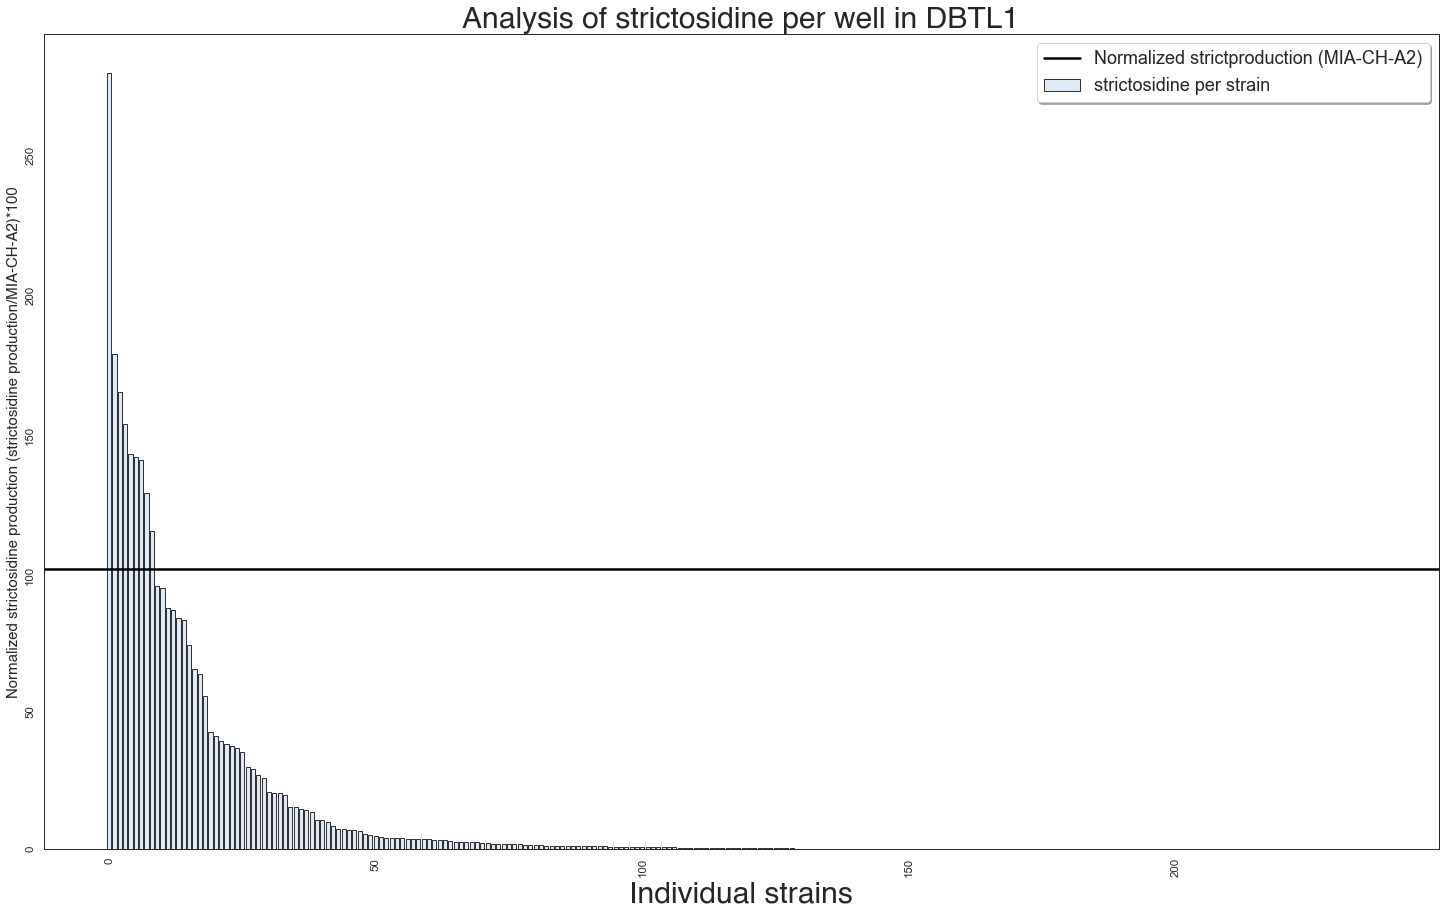

In [110]:
import matplotlib as mpl
from matplotlib.pyplot import figure

#### How can I export a matplotlib figure as a vector graphic with editable text fields?
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt

# Create Figure and Axes instances
fig,ax = plt.subplots(1)

# Plot
plt.bar(indexes, normalzed_strict, edgecolor='black', color = '#deebf7' ) # white
  
    
# Errorbar
#plt.errorbar(indexes, new_df_mean_list, yerr=new_df_SE_list, fmt="o", color="black",)# ms = 2)


# Change x labels rotation
ax.tick_params(rotation=90)

# Add labels and titel
ax.set_ylabel('Normalized strictosidine production (strictosidine production/MIA-CH-A2)*100', size = 15, fontname='Helvetica')
ax.set_xlabel('Individual strains', size = 30, fontname='Helvetica')
ax.set_title('Analysis of strictosidine per well in DBTL1', size = 30, fontname='Helvetica')
#plt.suptitle('Notes:\n - Triangels show individual measurements',x = 0.8,  y=0.7, fontsize=18, fontname='Helvetica')

# add horisontal line
plt.axhline(y = 100, color = 'black', linestyle = '-')

# Set color 
ax.set_facecolor("white")

# # Add legend
ax.legend(['Normalized strictproduction (MIA-CH-A2)', 'strictosidine per strain', 'Standard-Error (SE)', 'Individual datapoints'], loc='upper right', shadow=True, fontsize='x-large')


#### Addding all the datapoints as scatterplot
#x = indexes
#y = individual_strict_measurements_joined[:]
#length_of_dataset = individual_strict_measurements_joined[:]
#
#for i in range(len(individual_strict_measurements_joined)-1):
#    # add datapoint
#    if len(y[i]) > 1:
#        ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#        ax.scatter(x[i]  , y[i][1], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#    else: 
#        ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#
#ax.legend([ 'Individual datapoints'], loc='upper center', shadow=True, fontsize='x-large')

# SIze matters
fig = mpl.pyplot.gcf()
fig.set_size_inches(25, 15)

name = 'Analysis of strictosidine per well in DBTL1'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/DBTL1/'+name+'.pdf',format = 'pdf',  dpi = 300,bbox_inches='tight')

plt.show()

### Plotting all datapoints with standard deviation - errorbars

## 2.2 Genotyping

Purpose: Determine promoters from library strains to enable ML based sampling of library space

Methods:
DNA sequencing of assembled clusters. 


Genomic DNA was extracted from
overnight cultures using the LiOAc/SDS method adapted to a 96-well microtiter
plate format. Each extract was used as a template in 2 PCR reactions spanning
the 2 integrated promoter gene pairs and amplifying from 2500 to 3200 bp. The PCR
products were validated using a LabChip GX II (Perkin Elmer) and sequenced
using PlateSeq PCR Kits (Eurofins) according to the manufacturer’s instructions.
From the LabChip results, a PCR reaction was considered as trusted if it showed a
strong band of the correct size; not trusted if it showed a strong band of the wrong
size, and as no information (NI) gained if it showed a weak or no band. 


From the
sequencing results, a sequencing reaction was considered as trusted if it showed an
unambiguous sequence of the expected length (i.e., only limited by length of PCR
fragment, stretches of the same nucleotide in the promoter or of ~1 kb limit of
sanger sequencing reactions), not trusted if it showed an unambiguous sequence of
the expected length with an assembly error, and NI gained if there were no or bad
sequence results. If one or more sequencing results from the same strain showed
double peaks in the promoter region the strain was considered as a double
population. Finally, the promoter was noted as a failed assembly if either LabChip
and or sequencing results were considered not trusted, as NI if the sequencing
result was NI and else as the promoter predicted by pairwise alignment between
sequencing results and promoter sequence.

## 2.3 Sequencing

### Submission details


[Documents folder](ConStrain_on_google_colab/Data/raw/10_Sanger_results/Sanger/Submission/eurofins_upload_template_plateseq.xlsx)


Eurofins     | SDP_ID | cassette
------------ | ------ | --------
PCR_00020195 | yp49   | g8h
PCR_00020204 | yp50   | g8h
PCR_00020205 | yp51   | g8h
PCR_00020206 | yp49   | cpr
PCR_00020207 | yp50   | cpr
PCR_00020208 | yp51   | cpr

In plateseq kits well h12 is reserved for quality control.
In all 6 plates yp49-51 for g8h & cpr well h12 contains medium control which do not need to be sequenced. Thus no need to rearrange samples.

### Download and movement of files to correct folders 
[Eurofins Results](https://eurofinsgenomics.eu/pages)

In [111]:
path = 'ConStrain_on_google_colab/Data/raw/10_Sanger_results/'
files = os.listdir(path)
files

['ab1_second_round',
 'PlateReport_yp51_cpr.xls',
 '.DS_Store',
 'Sanger',
 'PlateReport_yp49_cpr.xls',
 'PlateReport_yp50_cpr.xls',
 'PlateReport_yp51_g8h.xls',
 'PlateReport_yp54_cpr_Run1.xlsx',
 'ab1',
 'PlateReport_yp53_g8h_Run1.xlsx',
 'PlateReport_yp54_g8h_Run1.xlsx',
 'PlateReport_yp50_g8h.xls',
 'PlateReport_yp53_cpr_Run1.xlsx',
 'PlateReport_yp49_g8h.xls',
 '.ipynb_checkpoints',
 'sanger_fasta']

In [112]:
yp49_cpr = pd.read_excel('../data/raw/10_Sanger_results/PlateReport_yp49_cpr.xls')
yp49_g8h = pd.read_excel('../data/raw/10_Sanger_results/PlateReport_yp49_g8h.xls')
yp50_cpr = pd.read_excel('../data/raw/10_Sanger_results/PlateReport_yp50_cpr.xls')
yp50_g8h = pd.read_excel('../data/raw/10_Sanger_results/PlateReport_yp50_g8h.xls')
yp51_cpr = pd.read_excel('../data/raw/10_Sanger_results/PlateReport_yp51_cpr.xls')
yp51_g8h = pd.read_excel('../data/raw/10_Sanger_results/PlateReport_yp51_g8h.xls')

# list of all the dataframes
sequencing_plates = [yp49_cpr, yp49_g8h, yp50_cpr, yp50_g8h, yp51_cpr, yp51_g8h]

In [113]:
from constrain.test.genotyping import slicing_and_naming_seq_plates, plat_seq_data_wrangler, plate_AvgQual, split_df_names, concatenating_list_of_dfs

In [114]:
len(sequencing_plates)

6

### Data wrangling of plateSeq2 excel files

In [115]:
#Slicing plate data
sliced_plates = slicing_and_naming_seq_plates(sequencing_plates)

# Making the values numeric
list_of_dfs = plat_seq_data_wrangler(sliced_plates)

#filter them on their 
filtered_plates = plate_AvgQual(list_of_dfs)

# Split names
split_df = split_df_names(filtered_plates)

# concatenating the plates
all_data_frames = concatenating_list_of_dfs(split_df)

#merged_with_genotyping
all_data_frames

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well
7,1,yp49_cpr_A1_pad_cpr_fw,57.51,1184,7.0,593.0,585,yp49,A1
9,3,yp49_cpr_C1_pad_cpr_fw,57.35,1097,6.0,591.0,584,yp49,C1
10,4,yp49_cpr_D1_pad_cpr_fw,57.43,1282,11.0,1057.0,1045,yp49,D1
11,5,yp49_cpr_E1_pad_cpr_fw,57.21,1192,5.0,594.0,588,yp49,E1
12,6,yp49_cpr_F1_pad_cpr_fw,57.00,1246,21.0,1097.0,1075,yp49,F1
...,...,...,...,...,...,...,...,...,...
60,54,yp51_g8h_D11_pad_g8h_fw,54.95,1206,14.0,1135.0,1120,yp51,D11
61,55,yp51_g8h_E11_pad_g8h_fw,57.72,1199,16.0,987.0,970,yp51,E11
62,56,yp51_g8h_A12_pad_g8h_fw,57.45,1167,18.0,987.0,968,yp51,A12
64,58,yp51_g8h_C12_pad_g8h_fw,57.46,1207,12.0,960.0,947,yp51,C12


In [116]:
## Adding a zero to all the numers before 10
wells = []
for index, row in all_data_frames.iterrows():
    if len(row['well']) == 2: 
        letter, number = row['well'][0:1], row['well'][1:2]
        #print(letter, number)
        row['well'] = letter + '0' + number
        wells.append(row['well'])
    else: 
        wells.append(row['well'])
        
        
all_data_frames['well'] = wells
all_data_frames

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well
7,1,yp49_cpr_A1_pad_cpr_fw,57.51,1184,7.0,593.0,585,yp49,A01
9,3,yp49_cpr_C1_pad_cpr_fw,57.35,1097,6.0,591.0,584,yp49,C01
10,4,yp49_cpr_D1_pad_cpr_fw,57.43,1282,11.0,1057.0,1045,yp49,D01
11,5,yp49_cpr_E1_pad_cpr_fw,57.21,1192,5.0,594.0,588,yp49,E01
12,6,yp49_cpr_F1_pad_cpr_fw,57.00,1246,21.0,1097.0,1075,yp49,F01
...,...,...,...,...,...,...,...,...,...
60,54,yp51_g8h_D11_pad_g8h_fw,54.95,1206,14.0,1135.0,1120,yp51,D11
61,55,yp51_g8h_E11_pad_g8h_fw,57.72,1199,16.0,987.0,970,yp51,E11
62,56,yp51_g8h_A12_pad_g8h_fw,57.45,1167,18.0,987.0,968,yp51,A12
64,58,yp51_g8h_C12_pad_g8h_fw,57.46,1207,12.0,960.0,947,yp51,C12


In [117]:
concating_all_plates_with_bad_reads = concatenating_list_of_dfs(sequencing_plates)
concating_all_plates_with_bad_reads = concating_all_plates_with_bad_reads.replace('n.a.', np.NaN)
concating_all_plates_with_bad_reads = split_df_names([concating_all_plates_with_bad_reads])[0]
concating_all_plates_with_bad_reads

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well
7,1,yp49_cpr_A1_pad_cpr_fw,57.51,1184,7.0,593.0,585,yp49,A1
8,2,yp49_cpr_B1_pad_cpr_fw,19.63,1029,115.0,144.0,28,yp49,B1
9,3,yp49_cpr_C1_pad_cpr_fw,57.35,1097,6.0,591.0,584,yp49,C1
10,4,yp49_cpr_D1_pad_cpr_fw,57.43,1282,11.0,1057.0,1045,yp49,D1
11,5,yp49_cpr_E1_pad_cpr_fw,57.21,1192,5.0,594.0,588,yp49,E1
...,...,...,...,...,...,...,...,...,...
62,56,yp51_g8h_A12_pad_g8h_fw,57.45,1167,18.0,987.0,968,yp51,A12
63,57,yp51_g8h_B12_pad_g8h_fw,18.65,1188,453.0,472.0,18,yp51,B12
64,58,yp51_g8h_C12_pad_g8h_fw,57.46,1207,12.0,960.0,947,yp51,C12
65,59,yp51_g8h_D12_pad_g8h_fw,28.14,1213,534.0,602.0,67,yp51,D12


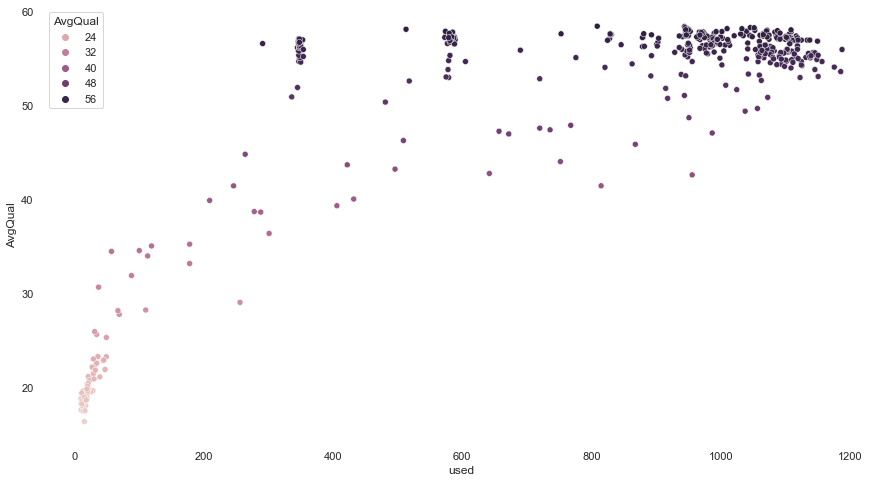

In [122]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style='white')


sns.scatterplot(data=concating_all_plates_with_bad_reads, x="used", y="AvgQual", hue="AvgQual")
sns.despine(bottom = True, left = True)

#g = sns.scatterplot(x="AvgQual", y="used", data=concating_all_plates_with_bad_reads)
None

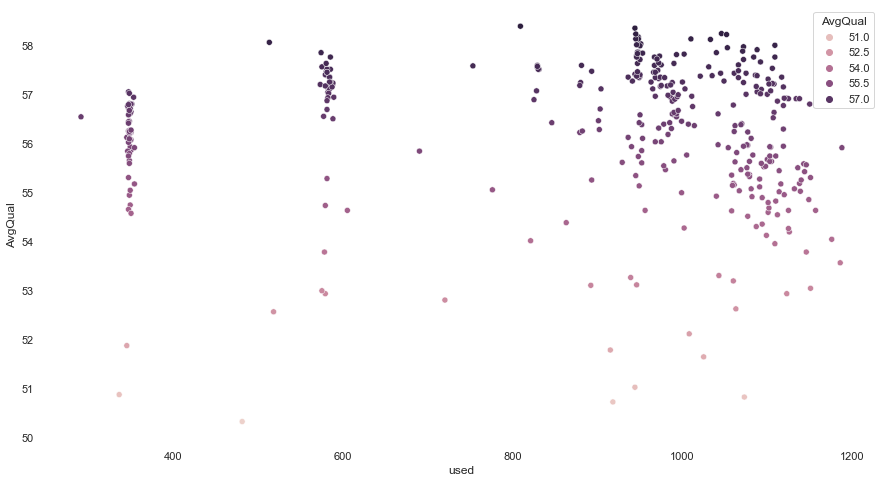

In [123]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style='white')


sns.scatterplot(data=all_data_frames, x="used", y="AvgQual", hue="AvgQual")
#g = sns.scatterplot(x="AvgQual", y="used", data=concating_all_plates_with_bad_reads)
sns.despine(bottom = True, left = True)

None

### Manual ab1 and promoter check 

### Detailed check of assemblies
- Manuel filtering. trusted / not_trusted ab1. 
- For certains strains multiple ab1 sequences get ambiguous only in promoters -> double population
- ab1 sequences quality drops preliminary due to stretches of same nucleotides in certain promoters  -> trusted even though small seq alignment 
- Low quality ab1 -> not_trusted


In [331]:
manual_checked = pd.read_excel('ConStrain_on_google_colab/Data/Sanger_seq_files/sequence_check2.xlsx')
manual_checked.head(10)

,plate,well,position,inf_promoter,ab1,ab1_comment,gel,gel_comment,if a larger part of the gene was not aligned due to N's,second alignment,Keep,Info
0,yp49,A01,2,5.0,good,good,good,good,NaN,NaN,True,"""-"" = empty"
1,yp49,A01,1,2.0,good,good,good,good,NaN,NaN,True,bad = not ambigous but does not align with pro...
2,yp49,A02,2,8.0,good,good,good,weak,NaN,NaN,True,bad = not ambigous but does not align with pro...
3,yp49,A02,1,3.0,good,good,good,good,NaN,NaN,True,NaN
4,yp49,A03,2,8.0,good,good,good,good,NaN,NaN,True,NaN
5,yp49,A03,1,3.0,good,good,good,good,NaN,NaN,True,NaN
6,yp49,A04,2,8.0,good,good,no_information,no_information,NaN,NaN,True,NaN
7,yp49,A04,1,3.0,good,good,good,good,NaN,NaN,True,NaN
8,yp49,A05,2,NaN,no_information,no_information,no_information,no_information,NaN,NaN,False,NaN
9,yp49,A05,1,3.0,good,good,good,good,NaN,NaN,True,NaN


Lets parse through the file and add the sequences to the all_sequences dataframe 

In [332]:
df_filterd_keep = manual_checked[manual_checked['Keep'] == True]

In [333]:
# making Sample-name from the information above
#yp49_cpr_A1_pad_cpr_fw	

sample_names = []
for index, row in df_filterd_keep.iterrows():
    if row['position'] == 1:
        name = 'g8h'
    if row['position'] == 2:
        name = 'cpr'
    
    # Getting the right nomeclature
    if row['well'][1] == '0': 
        well = row['well'][0]+row['well'][2]  
    else: 
        well = row['well']

    sample_name = f"{row['plate']}_{name}_{well}_pad_{name}_fw"
    
    sample_names.append(sample_name)
    
df_filterd_keep['Sample-Name'] = sample_names


df_filterd_keep['Line_name'] = df_filterd_keep['plate']+'_'+df_filterd_keep['well']

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_2431/1128589899.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filterd_keep['Sample-Name'] = sample_names
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_2431/1128589899.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filterd_keep['Line_name'] = df_filterd_keep['plate']+'_'+df_filterd_keep['well']


In [334]:
df_filterd_keep

,plate,well,position,inf_promoter,ab1,ab1_comment,gel,gel_comment,if a larger part of the gene was not aligned due to N's,second alignment,Keep,Info,Sample-Name,Line_name
0,yp49,A01,2,5.0,good,good,good,good,NaN,NaN,True,"""-"" = empty",yp49_cpr_A1_pad_cpr_fw,yp49_A01
1,yp49,A01,1,2.0,good,good,good,good,NaN,NaN,True,bad = not ambigous but does not align with pro...,yp49_g8h_A1_pad_g8h_fw,yp49_A01
2,yp49,A02,2,8.0,good,good,good,weak,NaN,NaN,True,bad = not ambigous but does not align with pro...,yp49_cpr_A2_pad_cpr_fw,yp49_A02
3,yp49,A02,1,3.0,good,good,good,good,NaN,NaN,True,NaN,yp49_g8h_A2_pad_g8h_fw,yp49_A02
4,yp49,A03,2,8.0,good,good,good,good,NaN,NaN,True,NaN,yp49_cpr_A3_pad_cpr_fw,yp49_A03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,yp51,E09,1,1.0,no_information,no_information,no_information,no_information,NaN,1,True,NaN,yp51_g8h_E9_pad_g8h_fw,yp51_E09
496,yp51,E11,2,7.0,no_information,no_information,NaN,NaN,NaN,7,True,NaN,yp51_cpr_E11_pad_cpr_fw,yp51_E11
497,yp51,E11,1,3.0,good,good,good,weak,NaN,NaN,True,NaN,yp51_g8h_E11_pad_g8h_fw,yp51_E11
498,yp51,E12,2,6.0,good,bad,NaN,NaN,NaN,6,True,NaN,yp51_cpr_E12_pad_cpr_fw,yp51_E12


In [335]:
# Sample-Name	inf_part_name	align_score	inf_part_number
df_filterd_keep = df_filterd_keep[['Sample-Name', 'inf_promoter', 'Line_name', 'position']]
df_filterd_keep.columns = ['Sample-Name', 'inf_part_number', 'Line_name','position']
df_filterd_keep.head()

,Sample-Name,inf_part_number,Line_name,position
0,yp49_cpr_A1_pad_cpr_fw,5.0,yp49_A01,2
1,yp49_g8h_A1_pad_g8h_fw,2.0,yp49_A01,1
2,yp49_cpr_A2_pad_cpr_fw,8.0,yp49_A02,2
3,yp49_g8h_A2_pad_g8h_fw,3.0,yp49_A02,1
4,yp49_cpr_A3_pad_cpr_fw,8.0,yp49_A03,2


## 2.4 Infering promoter to sample relationship

#### Primers used

In [336]:
from Bio import SeqIO

In [337]:
from constrain.lims.csv_database import get_dna_from_box_name
get_dna_from_box_name

<function constrain.lims.csv_database.get_dna_from_box_name(name: str, database_name: str, database_path='../data/csv_database/', genbank_files_path='../data/genbank_files/', genbank=False) -> Bio.SeqRecord.SeqRecord>

In [338]:
pad_pG8H_fw = get_dna_from_box_name('pad_pG8H_fw', 'primer_box', database_path = 'ConStrain_on_google_colab/Data/csv_database/')
pad_pCPR_fw = get_dna_from_box_name('pad_pCPR_fw', 'primer_box', database_path = 'ConStrain_on_google_colab/Data/csv_database/')


In [339]:
primers_for_seq = [pad_pG8H_fw, pad_pCPR_fw]
primers_for_seq

[SeqRecord(seq=Seq('TGCCCATTCGATAAGGCA'), id='10148.0', name='pad_pG8H_fw', description='Stock of primers for G8H-CPR library ', dbxrefs=[]),
 SeqRecord(seq=Seq('GGCGTATGGACCTGTCT'), id='10144.0', name='pad_pCPR_fw', description='Stock of primers for G8H-CPR library ', dbxrefs=[])]

#### Promoters to be aligned

In [340]:
pG8H_template_names = ['pCYC1','pENO2','pPCK1','pRPL15B']
pCPR_template_names = ['pCCW12','pMLS1','pTPI1','pURE2']

In [341]:
path = 'ConStrain_on_google_colab/Data/csv_database/'
genbank_path = 'ConStrain_on_google_colab/Data/genbank_files/'


pG8H_sites =[get_dna_from_box_name(name, 'ds_dna_box', database_path = path,genbank = True, genbank_files_path = genbank_path) for name in pG8H_template_names]  
pCPR_sites =[get_dna_from_box_name(name, 'ds_dna_box', database_path = path, genbank = True, genbank_files_path = genbank_path) for name in pCPR_template_names]  


In [342]:
templates = pCPR_sites+pG8H_sites

In [343]:
templates

[SeqRecord(seq=Seq('AAAGAAACTTAATACGTTATGCCGTAATGAAGGGCTACCAAAAACGATAATCTC...ATA'), id='10037', name='pCCW12', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('TTTAATCTTTAGGGAGGGTAAAGTTGGATTCATCAATTTGATGAAATCCGTGTA...AAA'), id='10038', name='pMLS1', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('AAGGATGAGCCAAGAATAAGGGAACAAGATTTTGGTAATTTCCAAAAAATCAAT...AAA'), id='10039', name='pTPI1', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('CAAGCTGAACTCGCTGAAATTGAAAGAAAACTGGCAGAATCGTCTTCTGAAGAC...CAA'), id='10040', name='pURE2', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('CAGCATTTTCAAAGGTGTGTTCTTCGTCAGACATGTTTTAGTGTGTGAATGAAA...ATA'), id='10033', name='pCYC1', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('AATCCTACTCTTGCCGTTGCCATCCAAAATGAGCTAGAAGGTGGATTAACAAAT...ATA'), id='10034', name='pENO2', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('CACATGTCGACGAGTTTGTCATCGAATCCGTAATGAAGGCGCAAGAAAAACTAG...AAC'), id='10035', name='pPCK1', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('GTACTG

#### ab1 reads to be analysed

In [344]:
path = 'ConStrain_on_google_colab/Data/raw/10_Sanger_results/ab1/'
files = os.listdir(path)
print(len(files))
reads = []
for read in files:
    if read.endswith('ab1'): 
        reads.append(SeqIO.read(path+read, 'abi'))


501


In [345]:
reads[12]

SeqRecord(seq=Seq('NNNNNNNNNNNGTANTGANNGGCTACCAAAAACGATAATCTCAACTGTAAACAG...NAA'), id='A-352518_F7', name='yp50_cpr_F7_pad_cpr_fw', description='', dbxrefs=[])

## 2.5 Aligning promoters to reads - infer promoter alignment

In [346]:
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]
numbers_list = [5, 7,6, 8, 1, 2, 3, 4]

for i in range(len(templates)): 
    templates[i].description = numbers_list[i]
    
templates

[SeqRecord(seq=Seq('AAAGAAACTTAATACGTTATGCCGTAATGAAGGGCTACCAAAAACGATAATCTC...ATA'), id='10037', name='pCCW12', description=5, dbxrefs=[]),
 SeqRecord(seq=Seq('TTTAATCTTTAGGGAGGGTAAAGTTGGATTCATCAATTTGATGAAATCCGTGTA...AAA'), id='10038', name='pMLS1', description=7, dbxrefs=[]),
 SeqRecord(seq=Seq('AAGGATGAGCCAAGAATAAGGGAACAAGATTTTGGTAATTTCCAAAAAATCAAT...AAA'), id='10039', name='pTPI1', description=6, dbxrefs=[]),
 SeqRecord(seq=Seq('CAAGCTGAACTCGCTGAAATTGAAAGAAAACTGGCAGAATCGTCTTCTGAAGAC...CAA'), id='10040', name='pURE2', description=8, dbxrefs=[]),
 SeqRecord(seq=Seq('CAGCATTTTCAAAGGTGTGTTCTTCGTCAGACATGTTTTAGTGTGTGAATGAAA...ATA'), id='10033', name='pCYC1', description=1, dbxrefs=[]),
 SeqRecord(seq=Seq('AATCCTACTCTTGCCGTTGCCATCCAAAATGAGCTAGAAGGTGGATTAACAAAT...ATA'), id='10034', name='pENO2', description=2, dbxrefs=[]),
 SeqRecord(seq=Seq('CACATGTCGACGAGTTTGTCATCGAATCCGTAATGAAGGCGCAAGAAAAACTAG...AAC'), id='10035', name='pPCK1', description=3, dbxrefs=[]),
 SeqRecord(seq=Seq('GTACTGCTGGCCA

In [347]:
# lets limit the alingment to only reads that are of proper quality
# all_data_frames
sample_names = df_filterd_keep['Sample-Name'].tolist()
print(len(sample_names))

good_samples = []
for i in range(len(reads)):
    for j in range(len(sample_names)): 
        if reads[i].name == sample_names[j]: 
            good_samples.append(reads[i])
            
            
len(good_samples)

381


381

In [348]:
from constrain.test.genotyping import pairwise_alignment_of_templates

In [349]:
len(templates)

8

## 2.6 Aligning the reads to the templates

In [88]:
%%time

df_alignment = pairwise_alignment_of_templates(good_samples,templates, primers_for_seq)

df_alignment

CPU times: user 14min 11s, sys: 2.72 s, total: 14min 14s
Wall time: 14min 14s


,Sample-Name,inf_part_name,align_score,inf_part_number
0,yp51_cpr_C2_pad_cpr_fw,pCCW12,751.0,5
1,yp49_g8h_D3_pad_g8h_fw,pPCK1,973.0,3
2,yp49_g8h_E6_pad_g8h_fw,pENO2,932.0,2
3,yp50_cpr_B12_pad_cpr_fw,pMLS1,964.0,7
4,yp51_cpr_E6_pad_cpr_fw,pMLS1,973.0,7
...,...,...,...,...
376,yp49_cpr_B10_pad_cpr_fw,pURE2,975.0,8
377,yp49_cpr_F11_pad_cpr_fw,pMLS1,968.0,7
378,yp49_cpr_A6_pad_cpr_fw,pTPI1,968.0,6
379,yp50_g8h_D3_pad_g8h_fw,pENO2,960.0,2


In [350]:
col_list =  list(df_alignment["align_score"])
print(col_list)

[751.0, 973.0, 932.0, 964.0, 973.0, 509.0, 966.0, 892.0, 968.0, 970.0, 518.0, 951.0, 525.0, 951.0, 503.0, 967.0, 859.0, 504.0, 968.0, 955.0, 966.0, 526.0, 972.0, 969.0, 970.0, 954.0, 969.0, 539.0, 959.0, 972.0, 972.0, 466.0, 949.0, 940.0, 444.0, 954.0, 968.0, 957.0, 756.0, 518.0, 679.0, 968.0, 933.0, 955.0, 544.0, 836.0, 955.0, 955.0, 870.0, 968.0, 856.0, 500.0, 501.0, 974.0, 912.0, 866.0, 793.0, 777.0, 785.0, 969.0, 308.0, 948.0, 969.0, 967.0, 950.0, 936.0, 955.0, 809.0, 970.0, 948.0, 532.0, 969.0, 680.0, 531.0, 838.0, 971.0, 967.0, 955.0, 948.0, 973.0, 527.0, 962.0, 955.0, 954.0, 961.0, 969.0, 918.0, 518.0, 751.0, 956.0, 951.0, 748.0, 971.0, 848.0, 969.0, 907.0, 831.0, 970.0, 970.0, 977.0, 971.0, 970.0, 954.0, 959.0, 949.0, 964.0, 953.0, 850.0, 969.0, 971.0, 516.0, 972.0, 956.0, 969.0, 531.0, 964.0, 936.0, 793.0, 959.0, 955.0, 518.0, 950.0, 529.0, 953.0, 964.0, 926.0, 734.0, 949.0, 973.0, 968.0, 972.0, 972.0, 485.0, 955.0, 810.0, 974.0, 794.0, 951.0, 973.0, 512.0, 964.0, 748.0, 954.0

In [351]:
minvalue = df_alignment['align_score'].min()
minvalue

308.0

In [352]:
df_align_sort = df_alignment.sort_values(['Sample-Name'])
df_align_sort.tail(10)

,Sample-Name,inf_part_name,align_score,inf_part_number,position
25,yp51_g8h_D9_pad_g8h_fw,pRPL15B,954.0,4,1
68,yp51_g8h_E11_pad_g8h_fw,pPCK1,970.0,3,1
170,yp51_g8h_E12_pad_g8h_fw,pCYC1,509.0,1,1
196,yp51_g8h_E1_pad_g8h_fw,pENO2,943.0,2,1
87,yp51_g8h_E2_pad_g8h_fw,pCYC1,518.0,1,1
39,yp51_g8h_E4_pad_g8h_fw,pCYC1,518.0,1,1
55,yp51_g8h_E5_pad_g8h_fw,pPCK1,866.0,3,1
132,yp51_g8h_E7_pad_g8h_fw,pCYC1,485.0,1,1
127,yp51_g8h_E8_pad_g8h_fw,pRPL15B,949.0,4,1
195,yp51_g8h_E9_pad_g8h_fw,pCYC1,521.0,1,1


In [353]:
df_alignment['position'] = ''
position = []
for index, row in df_alignment.iterrows():
    split = str(row['Sample-Name'].split("_")[1])
    if split == 'g8h': 
        position.append(1)
    if split == 'cpr': 
        position.append(2)

df_alignment['position'] = position
df_alignment

,Sample-Name,inf_part_name,align_score,inf_part_number,position
0,yp51_cpr_C2_pad_cpr_fw,pCCW12,751.0,5,2
1,yp49_g8h_D3_pad_g8h_fw,pPCK1,973.0,3,1
2,yp49_g8h_E6_pad_g8h_fw,pENO2,932.0,2,1
3,yp50_cpr_B12_pad_cpr_fw,pMLS1,964.0,7,2
4,yp51_cpr_E6_pad_cpr_fw,pMLS1,973.0,7,2
...,...,...,...,...,...
376,yp49_cpr_B10_pad_cpr_fw,pURE2,975.0,8,2
377,yp49_cpr_F11_pad_cpr_fw,pMLS1,968.0,7,2
378,yp49_cpr_A6_pad_cpr_fw,pTPI1,968.0,6,2
379,yp50_g8h_D3_pad_g8h_fw,pENO2,960.0,2,1


grouping the positions

In [354]:
grouped = df_alignment.groupby(df_alignment.position)
g8h_df = grouped.get_group(1)
cpr_df = grouped.get_group(2)

g8h_df

,Sample-Name,inf_part_name,align_score,inf_part_number,position
1,yp49_g8h_D3_pad_g8h_fw,pPCK1,973.0,3,1
2,yp49_g8h_E6_pad_g8h_fw,pENO2,932.0,2,1
5,yp49_g8h_B7_pad_g8h_fw,pCYC1,509.0,1,1
6,yp49_g8h_C2_pad_g8h_fw,pPCK1,966.0,3,1
10,yp49_g8h_G12_pad_g8h_fw,pCYC1,518.0,1,1
...,...,...,...,...,...
373,yp51_g8h_A6_pad_g8h_fw,pCYC1,503.0,1,1
374,yp50_g8h_B7_pad_g8h_fw,pPCK1,961.0,3,1
375,yp50_g8h_C2_pad_g8h_fw,pRPL15B,955.0,4,1
379,yp50_g8h_D3_pad_g8h_fw,pENO2,960.0,2,1


In [355]:
cpr_df

,Sample-Name,inf_part_name,align_score,inf_part_number,position
0,yp51_cpr_C2_pad_cpr_fw,pCCW12,751.0,5,2
3,yp50_cpr_B12_pad_cpr_fw,pMLS1,964.0,7,2
4,yp51_cpr_E6_pad_cpr_fw,pMLS1,973.0,7,2
7,yp50_cpr_F7_pad_cpr_fw,pCCW12,892.0,5,2
8,yp50_cpr_G2_pad_cpr_fw,pURE2,968.0,8,2
...,...,...,...,...,...
371,yp49_cpr_F7_pad_cpr_fw,pURE2,973.0,8,2
372,yp49_cpr_G12_pad_cpr_fw,pMLS1,966.0,7,2
376,yp49_cpr_B10_pad_cpr_fw,pURE2,975.0,8,2
377,yp49_cpr_F11_pad_cpr_fw,pMLS1,968.0,7,2


In [356]:
# lets merge the quality dataframe
# all_data_frames
infered_promoters_df = pd.merge(concating_all_plates_with_bad_reads, df_alignment, left_on=['Sample-Name'], right_on = ['Sample-Name'])

In [357]:
infered_promoters_df

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well,inf_part_name,align_score,inf_part_number,position
0,1,yp49_cpr_A1_pad_cpr_fw,57.51,1184,7.0,593.0,585,yp49,A1,pCCW12,833.0,5,2
1,3,yp49_cpr_C1_pad_cpr_fw,57.35,1097,6.0,591.0,584,yp49,C1,pCCW12,793.0,5,2
2,4,yp49_cpr_D1_pad_cpr_fw,57.43,1282,11.0,1057.0,1045,yp49,D1,pMLS1,972.0,7,2
3,5,yp49_cpr_E1_pad_cpr_fw,57.21,1192,5.0,594.0,588,yp49,E1,pCCW12,836.0,5,2
4,6,yp49_cpr_F1_pad_cpr_fw,57.00,1246,21.0,1097.0,1075,yp49,F1,pTPI1,969.0,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,55,yp51_g8h_E11_pad_g8h_fw,57.72,1199,16.0,987.0,970,yp51,E11,pPCK1,970.0,3,1
377,56,yp51_g8h_A12_pad_g8h_fw,57.45,1167,18.0,987.0,968,yp51,A12,pRPL15B,951.0,4,1
378,58,yp51_g8h_C12_pad_g8h_fw,57.46,1207,12.0,960.0,947,yp51,C12,pPCK1,960.0,3,1
379,59,yp51_g8h_D12_pad_g8h_fw,28.14,1213,534.0,602.0,67,yp51,D12,pMLS1,308.0,7,1


#### Comparing to the manually currated dataframe

In [358]:
indexes = []
new_inf_part = []
# manually curated
for index, row in df_filterd_keep.iterrows():
    
    # best pairwise alignment
    for index1, row1 in infered_promoters_df.iterrows():
        if row['Sample-Name'] == row1['Sample-Name']:
            if int(row['inf_part_number']) != int(row1['inf_part_number']):
                print('Not matching', row['inf_part_number'] , row1['inf_part_number'] , row['Sample-Name'] , row1['Sample-Name'])
                
                indexes.append(index1)
                new_inf_part.append(int(row['inf_part_number']))
                ## changing it to the manually curated one
                #infered_promoters_df.loc[index1].at['inf_part_number'] = 2
                #print('No match', row['inf_part_number'] , row1['inf_part_number'])


Not matching 2.0 7 yp51_g8h_D12_pad_g8h_fw yp51_g8h_D12_pad_g8h_fw


In [359]:
# changing that 
infered_promoters_df1 = infered_promoters_df.copy(deep=True)
infered_promoters_df1['inf_part_number'][indexes[0]] = 2

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_2431/3119800932.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infered_promoters_df1['inf_part_number'][indexes[0]] = 2


In [360]:
infered_promoters_df = infered_promoters_df1[["plate", "well", "inf_part_number", "position"]]
infered_promoters_df

,plate,well,inf_part_number,position
0,yp49,A1,5,2
1,yp49,C1,5,2
2,yp49,D1,7,2
3,yp49,E1,5,2
4,yp49,F1,6,2
...,...,...,...,...
376,yp51,E11,3,1
377,yp51,A12,4,1
378,yp51,C12,3,1
379,yp51,D12,2,1


In [361]:
well_list = infered_promoters_df['well'].to_list()

new_well_list = []
for i in range(len(well_list)): 
    if len(well_list[i]) == 2:
        
        well = str(well_list[i][0:1])+'0'+str(well_list[i][1:2])
        new_well_list.append(well)
        well= ''
        
    else: 
        new_well_list.append(well_list[i])

infered_promoters_df['well'] = new_well_list
infered_promoters_df

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_2431/100930297.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infered_promoters_df['well'] = new_well_list


,plate,well,inf_part_number,position
0,yp49,A01,5,2
1,yp49,C01,5,2
2,yp49,D01,7,2
3,yp49,E01,5,2
4,yp49,F01,6,2
...,...,...,...,...
376,yp51,E11,3,1
377,yp51,A12,4,1
378,yp51,C12,3,1
379,yp51,D12,2,1


In [362]:
# grouping
grouped = infered_promoters_df.groupby(infered_promoters_df.position)
g8h_df = grouped.get_group(1)
cpr_df = grouped.get_group(2)

#filtering
g8h_df = g8h_df[["plate", "well", "inf_part_number"]]
cpr_df = cpr_df[["plate", "well", "inf_part_number"]]

# changing names
g8h_df.columns = ['plate', 'well', 'inf_promoter1']
cpr_df.columns = ['plate', 'well', 'inf_promoter2']

promoter_to_well = pd.merge(g8h_df, cpr_df, left_on=['plate','well' ], right_on = ['plate','well'])
promoter_to_well

,plate,well,inf_promoter1,inf_promoter2
0,yp49,A01,2,5
1,yp49,C01,2,5
2,yp49,D01,4,7
3,yp49,E01,1,5
4,yp49,F01,3,6
...,...,...,...,...
147,yp51,E11,3,7
148,yp51,A12,4,7
149,yp51,C12,3,7
150,yp51,D12,2,7


In [363]:
print(len(g8h_df))
print(len(cpr_df))

218
163


Sanity check - did we get the correct promoters in each well? 


In [364]:
for index, row in promoter_to_well.iterrows():
    if int(row['inf_promoter1']) > 4:
        print('SOMTHING WRONG WITH G8H', row['plate'], row['well'], index,row['inf_promoter1'])
    if int(row['inf_promoter2']) < 5:
            print('SOMTHING WRONG WITH CPR', row['plate'], row['well'], index)
print('SUCCESSSSS')


SUCCESSSSS


## 2.7 Re-sequencing 

As shown above alot we lose alot of samples because many of the CPR samples did not meet the quality criteria. Therefore we re-sequenced some of the samples again. 

In [365]:
re_sequenced = pd.read_excel('ConStrain_on_google_colab/Data/Sanger_seq_files/ab1_first_round_resequencing/Mix2Seq - EF0000042174.xls')

# we can filter out the samples we need by only using samples with well not NAN
re_sequenced = re_sequenced[re_sequenced['Well'].notna()]
re_sequenced.head()

,Box,Tube Code,Rack Position,Strain,Primer,Date submitted,Results,Comment,Sample,Well
33,EF0000042207,EF20047945,C10,HA-43_F09_Rsep Ara_3 yp50 F09,pad_pG8H_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp50,F09
34,EF0000042208,EF20047946,C11,HA-42_F05_Rsep Aan_2 yp50 F05,pad_pG8H_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp50,F05
35,EF0000042209,EF20047947,C12,HA-39_E07_Smus Oeu_1 yp50 E07,pad_pG8H_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp50,E07
36,EF0000042210,EF20047948,D1,HA-83_A08_Oeu Ara_2 yp51 A08,pad_pCPR_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp51,A08
37,EF0000042211,EF20047949,D2,HA-82_A06_Oeu Aan_3 yp51 A06,pad_pCPR_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp51,A06


Importing the ab1 files

In [366]:
path = 'ConStrain_on_google_colab/Data/Sanger_seq_files/ab1_first_round_resequencing/'
files = os.listdir(path)

reads_reseq = []
for read in files:
    if read.endswith('ab1'): 
        reads_reseq.append(SeqIO.read(path+read, 'abi'))
        
print(len(reads_reseq))

40


In [367]:
reads_reseq[0]

SeqRecord(seq=Seq('CAACGTAGGGGGAAAGAAGGGCTTACCAAAAACGATAATCTCAACTGTAAACAG...AGG'), id='EF20047981', name='EF20047981_EF20047981', description='', dbxrefs=[])

In [368]:
# cross-ref the tube-codes
tube_codes = list(re_sequenced['Tube Code'])

In [369]:
# checking the reads match
i = 0
for name in reads_reseq: 
    if name.id not in tube_codes: 
        print(name.id)
    # the names for the reads are written like "id_id". we'll overwrite.
    name.name = name.id
i

0

In [370]:
reads_reseq[0]

SeqRecord(seq=Seq('CAACGTAGGGGGAAAGAAGGGCTTACCAAAAACGATAATCTCAACTGTAAACAG...AGG'), id='EF20047981', name='EF20047981', description='', dbxrefs=[])

In [110]:
%%time
df_alignment_reseq = pairwise_alignment_of_templates(reads_reseq,templates, primers_for_seq)

CPU times: user 1min 42s, sys: 409 ms, total: 1min 43s
Wall time: 1min 43s


In [371]:
df_alignment_reseq.head()

,Sample-Name,inf_part_name,align_score,inf_part_number
0,EF20047981,pCCW12,908.0,5
1,EF20047978,pTPI1,953.0,6
2,EF20047987,pCCW12,799.0,5
3,EF20047958,pURE2,981.0,8
4,EF20047980,pURE2,968.0,8


#### merging df_alignment_reseq and re-sequenced 

In [372]:
promoter_to_well_reseq = pd.merge( df_alignment_reseq,re_sequenced, left_on=['Sample-Name' ], right_on = ['Tube Code'])
len(promoter_to_well_reseq)

40

Getting the positions ie. g8h or cpr

In [373]:
positions =list(promoter_to_well_reseq['Primer'])
positions_for_df = []
for position in positions: 
    if position == 'pad_pCPR_fw': 
        positions_for_df.append(2)
    if position == 'pad_pG8H_fw': 
        positions_for_df.append(1)
promoter_to_well_reseq['position'] = positions_for_df

In [374]:
# 
promoter_to_well_reseq

,Sample-Name,inf_part_name,align_score,inf_part_number,Box,Tube Code,Rack Position,Strain,Primer,Date submitted,Results,Comment,Sample,Well,position
0,EF20047981,pCCW12,908.0,5,EF0000042239,EF20047981,F6,HA-39_E08_Smus Oeu_2 yp50 E08,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,E08,2
1,EF20047978,pTPI1,953.0,6,EF0000042236,EF20047978,F3,HA-45_G03_Rsep Rse_3 yp50 G0,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,G0,2
2,EF20047987,pCCW12,799.0,5,EF0000042243,EF20047987,F10,HA-32_C12_Smus Aan_3 yp50 C12,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,C12,2
3,EF20047958,pURE2,981.0,8,EF0000042218,EF20047958,D9,HA-42_F04_Rsep Aan_1 yp50 F04,pad_pCPR_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp50,F04,2
4,EF20047980,pURE2,968.0,8,EF0000042238,EF20047980,F5,HA-42_F04_Rsep Aan_1 yp50 F04,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,F04,2
5,EF20047959,pCCW12,939.0,5,EF0000042219,EF20047959,D10,HA-39_E08_Smus Oeu_2 yp50 E08,pad_pCPR_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp50,E08,2
6,EF20047986,pTPI1,959.0,6,EF0000042242,EF20047986,F9,HA-33_D03_Smus Ara_3 yp50 D03,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,D03,2
7,EF20047979,pCCW12,928.0,5,EF0000042237,EF20047979,F4,HA-44_F10_Rsep Clo_1 yp50 F10,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,F10,2
8,EF20047968,pTPI1,275.0,6,EF0000042226,EF20047968,E5,HA-76_G04_Cro Ahu_1 yp49 G04,pad_pCPR_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp49,G04,2
9,EF20047984,pURE2,964.0,8,EF0000042240,EF20047984,F7,HA-38_E06_Smus Cac_3 yp50 E06,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,E06,2


In [376]:
promoter_to_well_reseq.head()

,Sample-Name,inf_part_name,align_score,inf_part_number,Box,Tube Code,Rack Position,Strain,Primer,Date submitted,Results,Comment,Sample,Well,position
0,EF20047981,pCCW12,908.0,5,EF0000042239,EF20047981,F6,HA-39_E08_Smus Oeu_2 yp50 E08,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,E08,2
1,EF20047978,pTPI1,953.0,6,EF0000042236,EF20047978,F3,HA-45_G03_Rsep Rse_3 yp50 G0,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,G0,2
2,EF20047987,pCCW12,799.0,5,EF0000042243,EF20047987,F10,HA-32_C12_Smus Aan_3 yp50 C12,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,C12,2
3,EF20047958,pURE2,981.0,8,EF0000042218,EF20047958,D9,HA-42_F04_Rsep Aan_1 yp50 F04,pad_pCPR_fw,2021-08-20 00:00:00,NaN,ExoSAP,yp50,F04,2
4,EF20047980,pURE2,968.0,8,EF0000042238,EF20047980,F5,HA-42_F04_Rsep Aan_1 yp50 F04,pad_pCPR_fw,2021-08-20 00:00:00,NaN,Washed with ethanol,yp50,F04,2


In [381]:
promoter_to_well_reseq_filtered = promoter_to_well_reseq[['Sample', 'Well', 'inf_part_number', 'position']]
promoter_to_well_reseq_filtered.columns = ['plate', 'well', 'inf_part_number', 'position']
promoter_to_well_reseq_filtered['Line_name'] = promoter_to_well_reseq_filtered['plate']+'_'+promoter_to_well_reseq_filtered['well']
promoter_to_well_reseq_filtered.head()

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_2431/823718168.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promoter_to_well_reseq_filtered['Line_name'] = promoter_to_well_reseq_filtered['plate']+'_'+promoter_to_well_reseq_filtered['well']


,plate,well,inf_part_number,position,Line_name
0,yp50,E08,5,2,yp50_E08
1,yp50,G0,6,2,yp50_G0
2,yp50,C12,5,2,yp50_C12
3,yp50,F04,8,2,yp50_F04
4,yp50,F04,8,2,yp50_F04


#### manual curation

In [387]:
indexes = []

for index, row in promoter_to_well_reseq_filtered.iterrows():
    for index1, row1 in df_filterd_keep.iterrows():
        if row['Line_name'] == row1['Line_name'] and row['position'] == row1['position'] and int(row['inf_part_number']) != int(row1['position']):
            print()
            print('Problem')

In [380]:
df_filterd_keep

,Sample-Name,inf_part_number,Line_name,position
0,yp49_cpr_A1_pad_cpr_fw,5.0,yp49_A01,2
1,yp49_g8h_A1_pad_g8h_fw,2.0,yp49_A01,1
2,yp49_cpr_A2_pad_cpr_fw,8.0,yp49_A02,2
3,yp49_g8h_A2_pad_g8h_fw,3.0,yp49_A02,1
4,yp49_cpr_A3_pad_cpr_fw,8.0,yp49_A03,2
...,...,...,...,...
493,yp51_g8h_E9_pad_g8h_fw,1.0,yp51_E09,1
496,yp51_cpr_E11_pad_cpr_fw,7.0,yp51_E11,2
497,yp51_g8h_E11_pad_g8h_fw,3.0,yp51_E11,1
498,yp51_cpr_E12_pad_cpr_fw,6.0,yp51_E12,2


In [378]:
# concatenating with our previous dataframe 
infered_promoters_df = pd.concat([infered_promoters_df,promoter_to_well_reseq_filtered])

infered_promoters_df.tail()
print(len(infered_promoters_df))

421


In [379]:
# grouping
grouped = infered_promoters_df.groupby(infered_promoters_df.position)
g8h_df = grouped.get_group(1)
cpr_df = grouped.get_group(2)

#filtering
g8h_df = g8h_df[["plate", "well", "inf_part_number"]]
cpr_df = cpr_df[["plate", "well", "inf_part_number"]]

# changing names
g8h_df.columns = ['plate', 'well', 'inf_promoter1']
cpr_df.columns = ['plate', 'well', 'inf_promoter2']

promoter_to_well = pd.merge(g8h_df, cpr_df, left_on=['plate','well' ], right_on = ['plate','well'])
print(len(promoter_to_well))
promoter_to_well.head()

189


,plate,well,inf_promoter1,inf_promoter2
0,yp49,A01,2,5
1,yp49,C01,2,5
2,yp49,D01,4,7
3,yp49,E01,1,5
4,yp49,F01,3,6


In [395]:
promoter_to_well = promoter_to_well.drop_duplicates(ignore_index = True)
len(promoter_to_well)

172

In [396]:
df_filterd_keep

,Sample-Name,inf_part_number,Line_name,position
0,yp49_cpr_A1_pad_cpr_fw,5.0,yp49_A01,2
1,yp49_g8h_A1_pad_g8h_fw,2.0,yp49_A01,1
2,yp49_cpr_A2_pad_cpr_fw,8.0,yp49_A02,2
3,yp49_g8h_A2_pad_g8h_fw,3.0,yp49_A02,1
4,yp49_cpr_A3_pad_cpr_fw,8.0,yp49_A03,2
...,...,...,...,...
493,yp51_g8h_E9_pad_g8h_fw,1.0,yp51_E09,1
496,yp51_cpr_E11_pad_cpr_fw,7.0,yp51_E11,2
497,yp51_g8h_E11_pad_g8h_fw,3.0,yp51_E11,1
498,yp51_cpr_E12_pad_cpr_fw,6.0,yp51_E12,2


# 3. Combine data


In [432]:
promoter_genotype_relationship = pd.merge(promoter_to_well, sorted_df_lcms, on=['plate','well' ])
len(promoter_genotype_relationship)

169

In [433]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]


g8h_genotype = []
cpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in promoter_genotype_relationship.iterrows():
    g8h_geno = str(row['genotype'].split(" ")[0])
    cpr_geno = str(row['genotype'].split(" ")[1])
    
    
    g8h_pos = g8h_list_of_index.index(str(row['genotype'].split(" ")[0]))+1
    cpr_pos = cpr_list_of_index.index(str(row['genotype'].split(" ")[1]))+1

    
    g8h_genotype.append(g8h_pos)
    cpr_genotype.append(cpr_pos)
    
promoter_genotype_relationship['G8H'] = g8h_genotype
promoter_genotype_relationship['CPR'] = cpr_genotype

In [434]:
promoter_genotype_relationship['Line_name'] = promoter_genotype_relationship['plate']+ '_'+ promoter_genotype_relationship['well']

In [435]:
promoter_genotype_relationship

,plate,well,inf_promoter1,inf_promoter2,index,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,...,Amt_uM_Tryptophan,sample,strain,col_no,genotype,medium,norm_strict_%,G8H,CPR,Line_name
0,yp49,A01,2,5,0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.000000,0.0,...,0.0,96WP1056,MIA-HA-51,1.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.972701,1,1,yp49_A01
1,yp49,C01,2,5,22,210519_TMET517_044.xms,96WP1056_C01,0.0,0.000000,0.0,...,0.0,96WP1056,MIA-HA-59,1.0,CacuG8H OeuCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.536658,1,9,yp49_C01
2,yp49,D01,4,7,34,210519_TMET517_057.xms,96WP1056_D01,0.0,0.000000,0.0,...,0.0,96WP1056,MIA-HA-63,1.0,OpumG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.175896,2,3,yp49_D01
3,yp49,E01,1,5,46,210519_TMET517_083.xms,96WP1056_E01,0.0,0.000000,0.0,...,0.0,96WP1056,MIA-HA-67,1.0,OpumG8H AniCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.345201,2,7,yp49_E01
4,yp49,F01,3,6,58,210519_TMET517_096.xms,96WP1056_F01,0.0,1.350410,0.0,...,0.0,96WP1056,MIA-HA-71,1.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,26.416324,3,1,yp49_F01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,yp51,C12,3,7,213,210603_TMET525_186.xms,96WPYP51_C12,0.0,0.000000,0.0,...,0.0,96WPYP51,MIA-HA-92,3.0,CcalG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000,8,2,yp51_C12
165,yp51,D12,2,7,224,210603_TMET525_199.xms,96WPYP51_D12,0.0,0.000000,0.0,...,0.0,96WPYP51,MIA-HA-96,3.0,CcalG8H AhuCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.614962,8,6,yp51_D12
166,yp51,E12,1,6,235,210603_TMET525_225.xms,96WPYP51_E12,0.0,0.000000,0.0,...,0.0,96WPYP51,MIA-HA-100,3.0,CcalG8H CpoCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.466688,8,10,yp51_E12
167,yp50,F05,1,8,151,210603_TMET525_100.xms,96WPYP50_F5,0.0,0.000000,0.0,...,0.0,96WPYP50,MIA-HA-42,2.0,RsepG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,15.155009,6,2,yp50_F05


In [436]:
promoter_genotype_relationship = promoter_genotype_relationship[['Line_name', 'G8H','inf_promoter1', 'inf_promoter2', 'CPR',  'norm_strict_%']]
promoter_genotype_relationship.columns = ['Line_name',  '0','1', '2', '3',  'Amt_norm']

In [437]:
#find duplicate rows across all columns
duplicateRows = promoter_genotype_relationship[promoter_genotype_relationship.duplicated(['Line_name'], keep=False)]
print(len(duplicateRows))
print(duplicateRows)

2
   Line_name  0  1  2  3  Amt_norm
22  yp49_G04  3  2  6  6  4.263909
23  yp49_G04  3  2  7  6  4.263909


We cannot trust this ambiguity and will therefore drop the duplicated rows

In [443]:
promoter_genotype_relationship = promoter_genotype_relationship.drop_duplicates(subset = 'Line_name', keep=False)
promoter_genotype_relationship.head(50)

,Line_name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.972701
1,yp49_C01,1,2,5,9,0.536658
2,yp49_D01,2,4,7,3,0.175896
3,yp49_E01,2,1,5,7,0.345201
4,yp49_F01,3,3,6,1,26.416324
5,yp49_G01,3,2,7,5,3.989824
6,yp49_H01,3,3,8,9,0.460067
7,yp49_A02,1,3,8,1,0.269401
8,yp49_B02,1,2,8,5,0.255908
9,yp49_C02,1,3,8,9,0.169974


#### Export file

In [444]:
promoter_genotype_relationship.to_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_1st_iteration_all_analytics.csv',index=False )


In [6]:
input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_1st_iteration_all_analytics.csv', index_col=None)
input_for_ml

,Line_name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.972701
1,yp49_C01,1,2,5,9,0.536658
2,yp49_D01,2,4,7,3,0.175896
3,yp49_E01,2,1,5,7,0.345201
4,yp49_F01,3,3,6,1,26.416324
...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0.000000
163,yp51_D12,8,2,7,6,0.614962
164,yp51_E12,8,1,6,10,0.466688
165,yp50_F05,6,1,8,2,15.155009


# 4. Plotting the results:

In [7]:
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]

promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}
promoter_dict

{1: 'pCYC1',
 2: 'pENO2',
 3: 'pPCK1',
 4: 'pRPL15B',
 5: 'pCCW12',
 6: 'pTPI1',
 7: 'pMLS1',
 8: 'pURE2'}

In [8]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]


list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]

pg8h_list_of_index = ['pCYC1', 'pENO2']
pcpr_list_of_index = ['pCCW12', 'pTPI1'] 



g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in input_for_ml.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

input_for_ml['G8H'] = g8h_genotype
input_for_ml['CPR'] = cpr_genotype
input_for_ml['pG8H'] = pg8h_genotype
input_for_ml['pCPR'] = pcpr_genotype

In [9]:
for_plotting_input_for_ml = input_for_ml[['G8H', 'pG8H','pCPR', 'CPR']]
for_plotting_input_for_ml

,G8H,pG8H,pCPR,CPR
0,CacuG8H,pENO2,pCCW12,CroCPR
1,CacuG8H,pENO2,pCCW12,OeuCPR
2,OpumG8H,pRPL15B,pMLS1,AraCPR
3,OpumG8H,pCYC1,pCCW12,AniCPR
4,CroG8H,pPCK1,pTPI1,CroCPR
...,...,...,...,...
162,CcalG8H,pPCK1,pMLS1,AanCPR
163,CcalG8H,pENO2,pMLS1,AhuCPR
164,CcalG8H,pCYC1,pTPI1,CpoCPR
165,RsepG8H,pCYC1,pURE2,AanCPR


In [10]:
g8h_counts = pd.DataFrame(for_plotting_input_for_ml["G8H"].value_counts())
pg8h_counts = pd.DataFrame(for_plotting_input_for_ml["pG8H"].value_counts())
pcpr_counts = pd.DataFrame(for_plotting_input_for_ml["pCPR"].value_counts())
cpr_counts = pd.DataFrame(for_plotting_input_for_ml["CPR"].value_counts())

all_counts = pd.concat([g8h_counts,pg8h_counts,pcpr_counts, cpr_counts ])
all_counts

,G8H,pG8H,pCPR,CPR
VminG8H,23.0,NaN,NaN,NaN
SmusG8H,23.0,NaN,NaN,NaN
RsepG8H,21.0,NaN,NaN,NaN
OeuG8H,21.0,NaN,NaN,NaN
CcalG8H,21.0,NaN,NaN,NaN
CroG8H,20.0,NaN,NaN,NaN
CacuG8H,19.0,NaN,NaN,NaN
OpumG8H,19.0,NaN,NaN,NaN
pRPL15B,NaN,56.0,NaN,NaN
pPCK1,NaN,40.0,NaN,NaN


In [11]:
g8h_counts = dict(for_plotting_input_for_ml["G8H"].value_counts())
pg8h_counts = dict(for_plotting_input_for_ml["pG8H"].value_counts())
pcpr_counts = dict(for_plotting_input_for_ml["pCPR"].value_counts())
cpr_counts = dict(for_plotting_input_for_ml["CPR"].value_counts())

all_counts_as_list = [g8h_counts,pg8h_counts,pcpr_counts,cpr_counts]
all_counts_as_list

[{'VminG8H': 23,
  'SmusG8H': 23,
  'RsepG8H': 21,
  'OeuG8H': 21,
  'CcalG8H': 21,
  'CroG8H': 20,
  'CacuG8H': 19,
  'OpumG8H': 19},
 {'pRPL15B': 56, 'pPCK1': 40, 'pCYC1': 38, 'pENO2': 33},
 {'pURE2': 50, 'pCCW12': 43, 'pMLS1': 37, 'pTPI1': 37},
 {'AanCPR': 20,
  'CacCPR': 20,
  'AraCPR': 19,
  'RseCPR': 18,
  'AhuCPR': 18,
  'CroCPR': 16,
  'OeuCPR': 16,
  'CloCPR': 16,
  'CpoCPR': 13,
  'AniCPR': 11}]

In [12]:
def counting_occurences(data_with_occurences:dict): 
    columns = []
    data = []
    for key,value in data_with_occurences.items(): 

        values = cpr_counts.values()
        total = sum(values)

        data.append((value/total)*100)
        columns.append(key)
        
    return data, columns

In [13]:
# Occurences
names_list = ['G8H', 'pG8H', 'pCPR', 'CPR']

dataframes = []
for i in range(len(all_counts_as_list)): 
    data, columns = counting_occurences(all_counts_as_list[i])

    dataframes.append(pd.DataFrame(data, columns=[names_list[i]], index=columns))

    print(data, columns)

[13.77245508982036, 13.77245508982036, 12.574850299401197, 12.574850299401197, 12.574850299401197, 11.976047904191617, 11.377245508982035, 11.377245508982035] ['VminG8H', 'SmusG8H', 'RsepG8H', 'OeuG8H', 'CcalG8H', 'CroG8H', 'CacuG8H', 'OpumG8H']
[33.532934131736525, 23.952095808383234, 22.75449101796407, 19.760479041916167] ['pRPL15B', 'pPCK1', 'pCYC1', 'pENO2']
[29.94011976047904, 25.748502994011975, 22.15568862275449, 22.15568862275449] ['pURE2', 'pCCW12', 'pMLS1', 'pTPI1']
[11.976047904191617, 11.976047904191617, 11.377245508982035, 10.778443113772456, 10.778443113772456, 9.580838323353294, 9.580838323353294, 9.580838323353294, 7.784431137724551, 6.58682634730539] ['AanCPR', 'CacCPR', 'AraCPR', 'RseCPR', 'AhuCPR', 'CroCPR', 'OeuCPR', 'CloCPR', 'CpoCPR', 'AniCPR']


In [14]:
all_df_for_stacked_plot = pd.concat(dataframes)
all_df_for_stacked_plot = all_df_for_stacked_plot.T
all_df_for_stacked_plot

,VminG8H,SmusG8H,RsepG8H,OeuG8H,CcalG8H,CroG8H,CacuG8H,OpumG8H,pRPL15B,pPCK1,...,AanCPR,CacCPR,AraCPR,RseCPR,AhuCPR,CroCPR,OeuCPR,CloCPR,CpoCPR,AniCPR
G8H,13.772455,13.772455,12.57485,12.57485,12.57485,11.976048,11.377246,11.377246,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pG8H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.532934,23.952096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pCPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.976048,11.976048,11.377246,10.778443,10.778443,9.580838,9.580838,9.580838,7.784431,6.586826


#### Parts distribution

In [15]:
G8H_list = list(simple_plotting['G8H'])
pG8H_list = list(simple_plotting['pG8H'])
pCPR_list = list(simple_plotting['pCPR'])
CPR_list = list(simple_plotting['CPR'])

NameError: name 'simple_plotting' is not defined

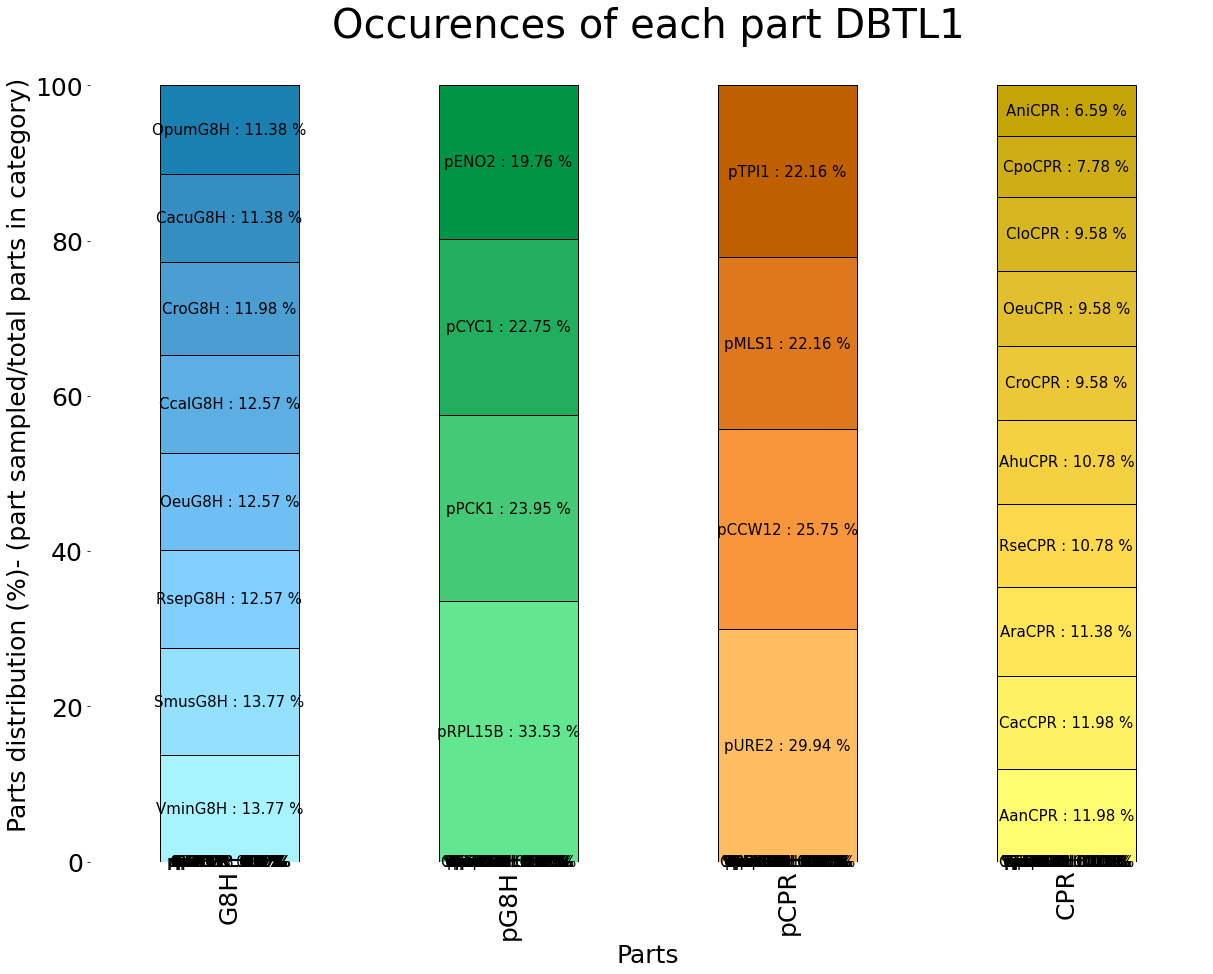

In [27]:
import seaborn as sns

g8h_color = ['#1a7fb1', '#358ec1', '#4a9ed2', '#5daee3', '#6fbef4', '#81cffe', '#94e1ff', '#a7f3ff']#,'#4292c6','#2171b5','#08519c','#08519c']
pg8H_color = ['#009446', '#21af5f', '#44ca77', '#63e690']
pcpr_color = ['#bf5f00', '#de781d', '#f9963c', '#ffbd62']
cpr_color = ['#c5a505', '#cfae15', '#d8b622', '#e2bf2e', '#ecc738', '#f5d041', '#fed94b', '#ffe557', '#fff163', '#fffd6f']

pg8H_color =pg8H_color[::-1]
pcpr_color = pcpr_color[::-1]
cpr_color = cpr_color[::-1]
g8h_color = g8h_color[::-1]
all_colors1 = g8h_color+ pg8H_color+ pcpr_color  +cpr_color


ax = all_df_for_stacked_plot.plot( kind="bar",stacked = True,  figsize=(20, 15), color=all_colors1,  edgecolor='Black') # , cmap="coolwarm"
# Add Title and Labels
plt.title('Occurences of each part DBTL1', fontsize=40)
plt.xlabel('Parts', fontsize=25)
plt.ylabel('Parts distribution (%)- (part sampled/total parts in category)', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)

# removes the borders around the plot
sns.despine(bottom = True, left = True)
ax.legend([],[],frameon=False) # around the legend

labels_for_test = []
# adding laves to each box
for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    #labels = [round(v.get_height()*100,2)  if v.get_height() > 0 else '' for v in c]
    
    # this one writes label and percent 
    labels_for_bars = [f"{c.get_label()} : {round(v.get_height(),2)} %"  for v in c]
    labels = [f"{c.get_label()}"  for v in c]

    labels_for_test.append(c.get_label())
    #for barcontainer in ax.containers:
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels_for_bars, label_type='center', fmt='str', size = 15)
    
name = 'Occurences of each part sampled'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/DBTL1/'+name+'.pdf',format = 'pdf',  dpi = 120)




#### Top20 Strains

In [600]:
first_round_top_producers = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_1st_iteration_all_analytics.csv')
first_round_top_producers = first_round_top_producers.sort_values(by='Amt_norm', ascending=False)

In [601]:
first_round_top_producers

,Line_name,0,1,2,3,Amt_norm
73,yp50_D03,5,2,6,3,277.307816
75,yp50_G03,6,2,6,5,176.917201
86,yp50_E05,5,1,6,8,163.352037
106,yp50_A09,4,2,6,3,152.013305
126,yp51_A02,7,2,6,1,141.151036
...,...,...,...,...,...,...
60,yp50_E01,5,3,5,7,0.000000
114,yp50_D11,5,4,8,6,0.000000
24,yp49_E05,2,3,7,8,0.000000
27,yp49_H05,3,3,7,10,0.000000


In [602]:
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]

promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}


g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]


list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]

pg8h_list_of_index = ['pCYC1', 'pENO2']
pcpr_list_of_index = ['pCCW12', 'pTPI1'] 



g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in first_round_top_producers.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

first_round_top_producers['G8H'] = g8h_genotype
first_round_top_producers['CPR'] = cpr_genotype
first_round_top_producers['pG8H'] = pg8h_genotype
first_round_top_producers['pCPR'] = pcpr_genotype
first_round_top_producers

,Line_name,0,1,2,3,Amt_norm,G8H,CPR,pG8H,pCPR
73,yp50_D03,5,2,6,3,277.307816,SmusG8H,AraCPR,pENO2,pTPI1
75,yp50_G03,6,2,6,5,176.917201,RsepG8H,RseCPR,pENO2,pTPI1
86,yp50_E05,5,1,6,8,163.352037,SmusG8H,CacCPR,pCYC1,pTPI1
106,yp50_A09,4,2,6,3,152.013305,VminG8H,AraCPR,pENO2,pTPI1
126,yp51_A02,7,2,6,1,141.151036,OeuG8H,CroCPR,pENO2,pTPI1
...,...,...,...,...,...,...,...,...,...,...
60,yp50_E01,5,3,5,7,0.000000,SmusG8H,AniCPR,pPCK1,pCCW12
114,yp50_D11,5,4,8,6,0.000000,SmusG8H,AhuCPR,pRPL15B,pURE2
24,yp49_E05,2,3,7,8,0.000000,OpumG8H,CacCPR,pPCK1,pMLS1
27,yp49_H05,3,3,7,10,0.000000,CroG8H,CpoCPR,pPCK1,pMLS1


In [603]:
top_producers_1st = first_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR','Amt_norm' ]]
top_producers_1st

,G8H,pG8H,pCPR,CPR,Amt_norm
73,SmusG8H,pENO2,pTPI1,AraCPR,277.307816
75,RsepG8H,pENO2,pTPI1,RseCPR,176.917201
86,SmusG8H,pCYC1,pTPI1,CacCPR,163.352037
106,VminG8H,pENO2,pTPI1,AraCPR,152.013305
126,OeuG8H,pENO2,pTPI1,CroCPR,141.151036
...,...,...,...,...,...
60,SmusG8H,pPCK1,pCCW12,AniCPR,0.000000
114,SmusG8H,pRPL15B,pURE2,AhuCPR,0.000000
24,OpumG8H,pPCK1,pMLS1,CacCPR,0.000000
27,CroG8H,pPCK1,pMLS1,CpoCPR,0.000000


In [604]:
# Using DataFrame.agg() to combine two columns of text
top_producers_1st["Names"] = top_producers_1st[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
#top_producers_1st = top_producers_1st.sort_values(by= 'Amt_norm' , ascending = True)

first_round_top_producers_TOP20 = top_producers_1st[:20][::-1]
first_round_top_producers_TOP20= first_round_top_producers_TOP20.reset_index()

first_round_top_producers_TOP20

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_2431/1974076612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_producers_1st["Names"] = top_producers_1st[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)


,index,G8H,pG8H,pCPR,CPR,Amt_norm,Names
0,71,VminG8H,pCYC1,pCCW12,RseCPR,41.771069,VminG8H-pCYC1-pCCW12-RseCPR
1,52,CroG8H,pCYC1,pTPI1,CacCPR,54.695171,CroG8H-pCYC1-pTPI1-CacCPR
2,112,RsepG8H,pENO2,pURE2,CacCPR,62.521844,RsepG8H-pENO2-pURE2-CacCPR
3,72,VminG8H,pENO2,pTPI1,OeuCPR,64.567815,VminG8H-pENO2-pTPI1-OeuCPR
4,90,SmusG8H,pENO2,pURE2,CacCPR,72.949151,SmusG8H-pENO2-pURE2-CacCPR
5,104,SmusG8H,pCYC1,pCCW12,OeuCPR,81.980435,SmusG8H-pCYC1-pCCW12-OeuCPR
6,25,CroG8H,pENO2,pTPI1,AanCPR,82.644068,CroG8H-pENO2-pTPI1-AanCPR
7,166,SmusG8H,pCYC1,pTPI1,OeuCPR,85.594690,SmusG8H-pCYC1-pTPI1-OeuCPR
8,62,RsepG8H,pCYC1,pCCW12,RseCPR,86.198831,RsepG8H-pCYC1-pCCW12-RseCPR
9,100,VminG8H,pENO2,pCCW12,AraCPR,93.349565,VminG8H-pENO2-pCCW12-AraCPR


In [605]:
indexes_top20 = list(first_round_top_producers_TOP20.index)
names_top20 = list(first_round_top_producers_TOP20['Names'])
normalized_strict_top20 = list(first_round_top_producers_TOP20['Amt_norm'])

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


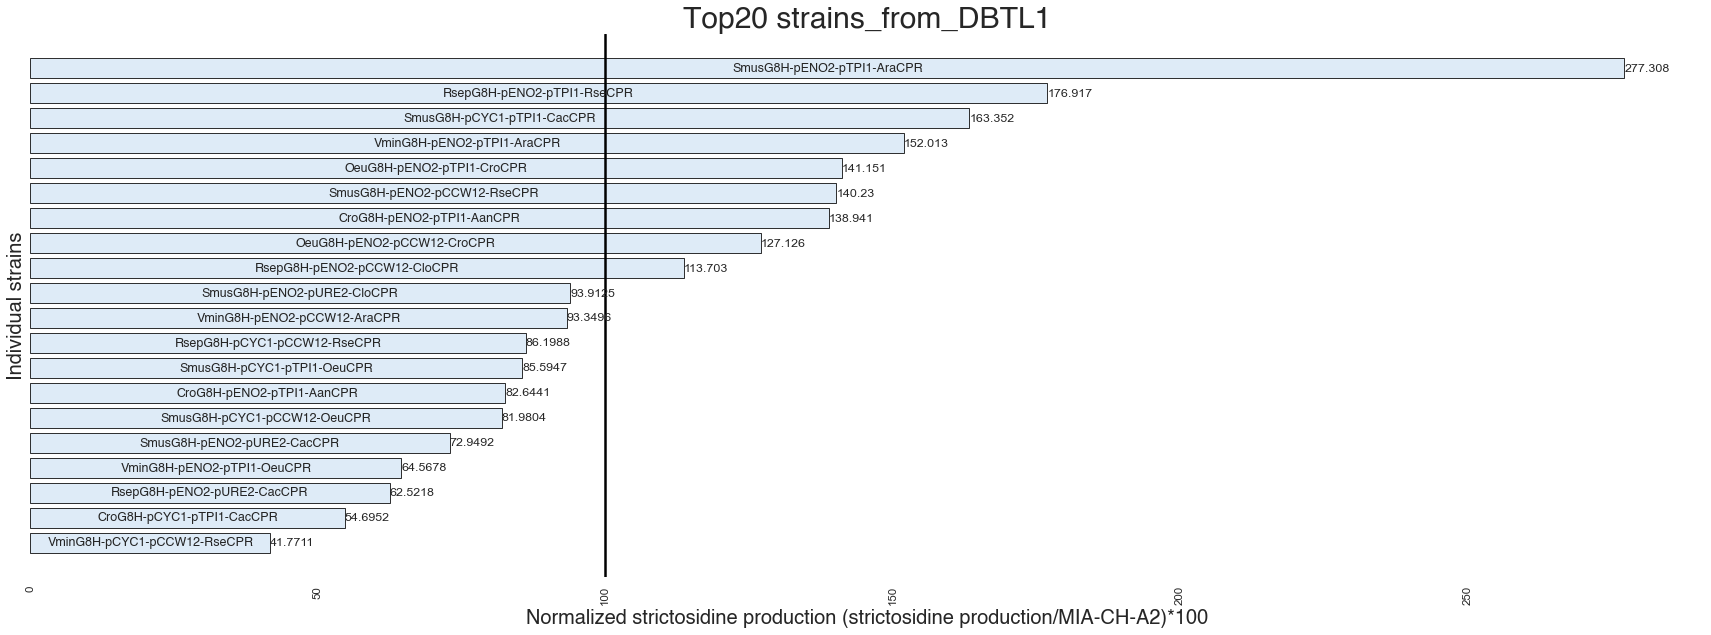

In [672]:
import matplotlib as mpl
from matplotlib.pyplot import figure

#### How can I export a matplotlib figure as a vector graphic with editable text fields?
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42



import matplotlib.pyplot as plt

# Create Figure and Axes instances
fig,ax = plt.subplots(1)

# Plot
plt.barh(indexes_top20, normalized_strict_top20, edgecolor='black', color = '#deebf7' ) # white

# Change x labels rotation
ax.tick_params(rotation=90)

# Add labels and titel
ax.set_xlabel('Normalized strictosidine production (strictosidine production/MIA-CH-A2)*100', size = 20, fontname='Helvetica')
ax.set_ylabel('Individual strains', size = 20, fontname='Helvetica')
ax.set_title('Top20 strains_from_DBTL1', size = 30, fontname='Helvetica')
#plt.suptitle('Notes:\n - Triangels show individual measurements',x = 0.8,  y=0.7, fontsize=18, fontname='Helvetica')

# remove gridlines
ax.grid(False)

# Background
ax.set_facecolor("white")


# add horisontal line
plt.axvline(x = 100, color = 'black', label = 'Normalized strict production', linestyle = '-')

# remove y labels
plt.yticks([])

## adding the labels on the bar
for c in ax.containers:
    ax.bar_label(c, labels=names_top20, label_type='center', fontname = 'Helvetica')
    ax.bar_label(c)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


# SIze matters
fig = mpl.pyplot.gcf()
fig.set_size_inches(30, 10)

name = 'Top20 strains_from_DBTL1'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/DBTL1/'+name+'.pdf',format = 'pdf',  dpi = 300,bbox_inches='tight')
#
plt.show()